In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [10]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [15]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [17]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [383]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---

# portfolio
exchange = cfg['portfolio']['exchange']
portfolio_name = cfg['portfolio']['name']

start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()
warmup_days = int(cfg['run']['warmup_days'])
long_only = cfg['run']['long_only']
annual_trading_days    = int(cfg['run']['annual_trading_days'])
initial_capital        = float(cfg['run']['initial_capital'])

# universe
ticker_list = list(cfg['universe']['tickers'])

# data
use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])
price_or_returns_calc    = str(cfg['data']['price_or_returns_calc'])
moving_avg_type    = str(cfg['data']['moving_avg_type'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# risk_and_sizing
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])
rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])
rolling_sharpe_window    = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])

# execution_and_costs
transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])
min_trade_notional_abs = float(cfg['execution_and_costs']['min_trade_notional_abs'])
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

In [21]:
use_saved_files

True

In [106]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2753853358168141,
 'annualized_sharpe_ratio': 1.2297193387033585,
 'calmar_ratio': 1.6289999017207646,
 'annualized_std_dev': 0.3971031922886883,
 'max_drawdown': -0.1690517817256562,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.771813779595924,
 'p_value': 0.0056594559018005725,
 'trade_count': 161.0}

In [108]:
ticker_perf_prod_config = {}
for t in cfg['universe']['tickers']:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_prod_config,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config[t] = _ticker_perf

In [110]:
ticker_perf_prod_config

{'BTC-USD': {'annualized_return': 0.06982390814356143,
  'annualized_sharpe_ratio': 0.26244384664420484,
  'calmar_ratio': 0.8416927133190821,
  'annualized_std_dev': 0.20587347542227852,
  'max_drawdown': -0.08295653156865514,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08374384236453201,
  't_statistic': 1.5318381374949266,
  'p_value': 0.1258222726952903,
  'trade_count': 205},
 'ETH-USD': {'annualized_return': 0.09196577667156114,
  'annualized_sharpe_ratio': 0.5566946293876285,
  'calmar_ratio': 0.8348031596554858,
  'annualized_std_dev': 0.2066495900046399,
  'max_drawdown': -0.1101646245679214,
  'max_drawdown_duration': Timedelta('507 days 00:00:00'),
  'hit_rate': 0.07307060755336617,
  't_statistic': 2.198078136774348,
  'p_value': 0.02813131205776444,
  'trade_count': 159},
 'SOL-USD': {'annualized_return': 0.048825027271480304,
  'annualized_sharpe_ratio': 0.014825603198136366,
  'calmar_ratio': 1.6743726653658395,
  'annualized_std_dev': 0.36

In [116]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

# ticker_list = list(cfg['universe']['tickers'])
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD', 'LTC-USD', 'DOGE-USD', 'CRO-USD']

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])
min_trade_notional_abs = float(cfg['execution_and_costs']['min_trade_notional_abs'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [118]:
ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'ADA-USD',
 'AVAX-USD',
 'LTC-USD',
 'DOGE-USD',
 'CRO-USD']

In [122]:
df_final_prod_config_expanded = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config_expanded = df_final_prod_config_expanded[df_final_prod_config_expanded.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_expanded = perf.calculate_asset_level_returns(df_final_prod_config_expanded, end_date, ticker_list)

portfolio_perf_metrics_prod_config_expanded = calculate_risk_and_performance_metrics(df_final_prod_config_expanded, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_expanded

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
LTC-USD
DOGE-USD
CRO-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2663882716096857,
 'annualized_sharpe_ratio': 1.1408221947783335,
 'calmar_ratio': 1.6380227916339998,
 'annualized_std_dev': 0.3998958458850229,
 'max_drawdown': -0.1626279395929233,
 'max_drawdown_duration': Timedelta('302 days 00:00:00'),
 'hit_rate': 0.14203612479474548,
 't_statistic': 2.585166808646033,
 'p_value': 0.009848655615997258,
 'trade_count': 191.0}

In [124]:
ticker_perf_prod_config_expanded = {}
for t in ticker_list:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_prod_config_expanded,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config_expanded[t] = _ticker_perf

In [126]:
ticker_perf_prod_config

{'BTC-USD': {'annualized_return': 0.06982390814356143,
  'annualized_sharpe_ratio': 0.26244384664420484,
  'calmar_ratio': 0.8416927133190821,
  'annualized_std_dev': 0.20587347542227852,
  'max_drawdown': -0.08295653156865514,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08374384236453201,
  't_statistic': 1.5318381374949266,
  'p_value': 0.1258222726952903,
  'trade_count': 205},
 'ETH-USD': {'annualized_return': 0.09196577667156114,
  'annualized_sharpe_ratio': 0.5566946293876285,
  'calmar_ratio': 0.8348031596554858,
  'annualized_std_dev': 0.2066495900046399,
  'max_drawdown': -0.1101646245679214,
  'max_drawdown_duration': Timedelta('507 days 00:00:00'),
  'hit_rate': 0.07307060755336617,
  't_statistic': 2.198078136774348,
  'p_value': 0.02813131205776444,
  'trade_count': 159},
 'SOL-USD': {'annualized_return': 0.048825027271480304,
  'annualized_sharpe_ratio': 0.014825603198136366,
  'calmar_ratio': 1.6743726653658395,
  'annualized_std_dev': 0.36

In [128]:
ticker_perf_prod_config_expanded

{'BTC-USD': {'annualized_return': 0.02819481992889794,
  'annualized_sharpe_ratio': -0.36023302367543375,
  'calmar_ratio': 0.4139334872850315,
  'annualized_std_dev': 0.1324385206522665,
  'max_drawdown': -0.06811437294872255,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08292282430213464,
  't_statistic': 0.986533175399649,
  'p_value': 0.3240676342271769,
  'trade_count': 204},
 'ETH-USD': {'annualized_return': 0.0905609163705201,
  'annualized_sharpe_ratio': 0.5535322626099464,
  'calmar_ratio': 0.9223149911448054,
  'annualized_std_dev': 0.2164040958533258,
  'max_drawdown': -0.09818870693851907,
  'max_drawdown_duration': Timedelta('502 days 00:00:00'),
  'hit_rate': 0.06239737274220033,
  't_statistic': 2.2276002092475284,
  'p_value': 0.02608945816384652,
  'trade_count': 136},
 'SOL-USD': {'annualized_return': 0.03756453262660142,
  'annualized_sharpe_ratio': -0.1679428489151424,
  'calmar_ratio': 1.2220938015775438,
  'annualized_std_dev': 0.4280

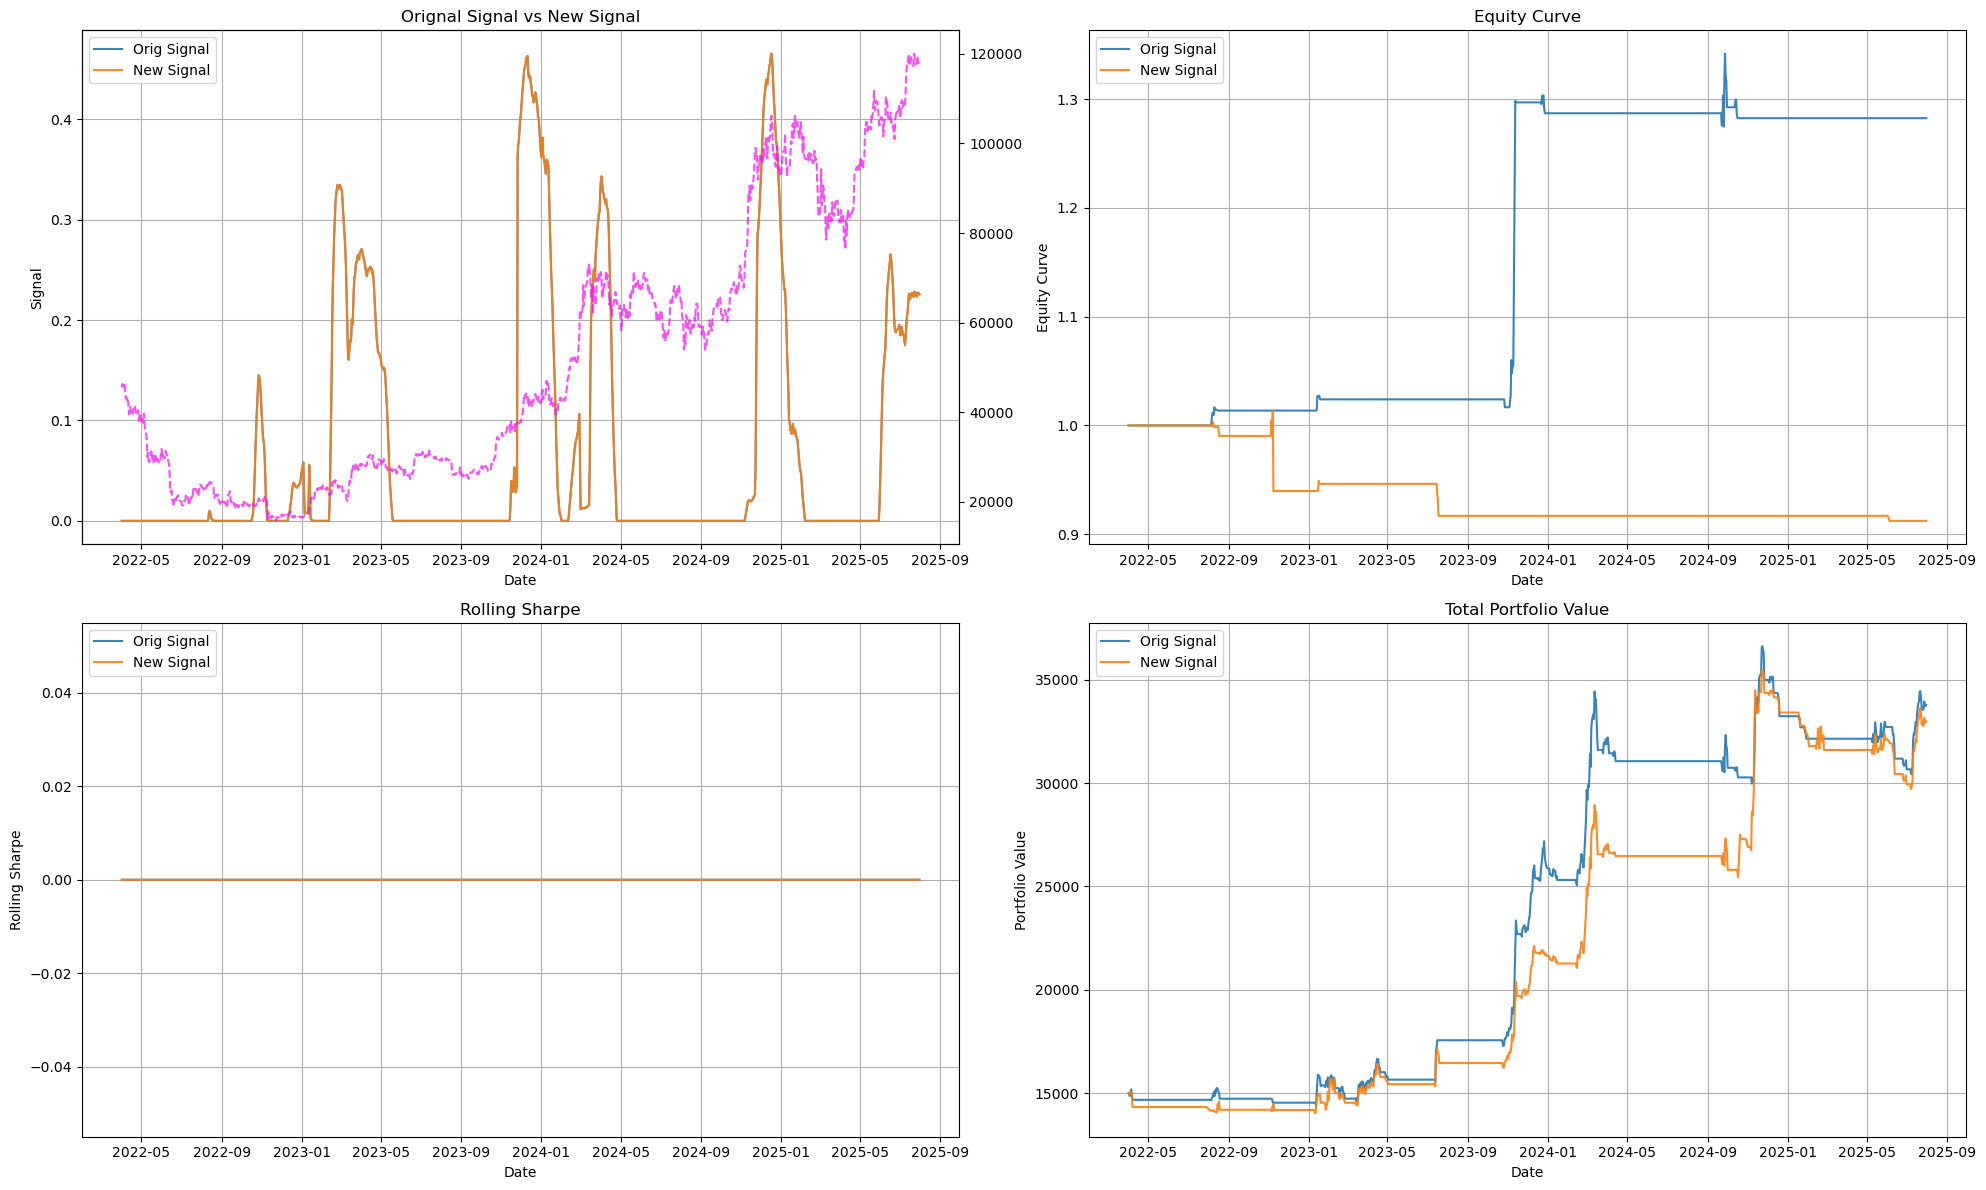

In [130]:
plot_signal_performance(df_1=df_final_prod_config, df_2=df_final_prod_config_expanded, ticker='BTC-USD')

In [132]:
df_final_prod_config_expanded.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,LTC-USD_20_avg_true_range_price,LTC-USD_actual_position_notional,LTC-USD_actual_position_size,LTC-USD_annualized_volatility_30,LTC-USD_close,LTC-USD_cooldown_counter,LTC-USD_event,LTC-USD_final_signal,LTC-USD_final_weighted_additive_signal,LTC-USD_highest_high_56,LTC-USD_lowest_low_56,LTC-USD_new_position_entry_exit_price,LTC-USD_new_position_notional,LTC-USD_new_position_size,LTC-USD_open,LTC-USD_open_position_notional,LTC-USD_open_position_size,LTC-USD_short_sale_proceeds,LTC-USD_stop_loss,LTC-USD_stopout_flag,LTC-USD_t_1_close,LTC-USD_t_1_close_pct_returns,LT

<Axes: xlabel='date'>

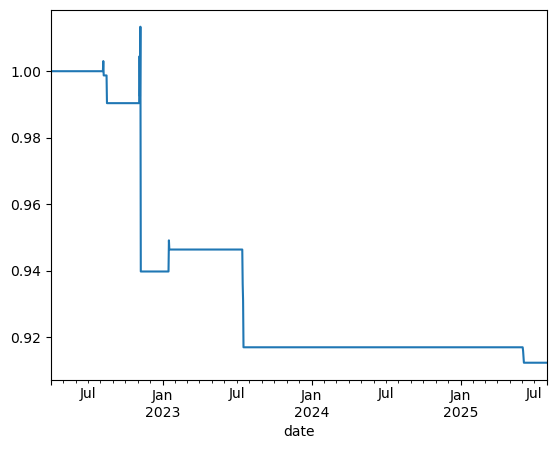

In [134]:
df_final_prod_config_expanded['equity_curve'].plot()

<Axes: xlabel='date'>

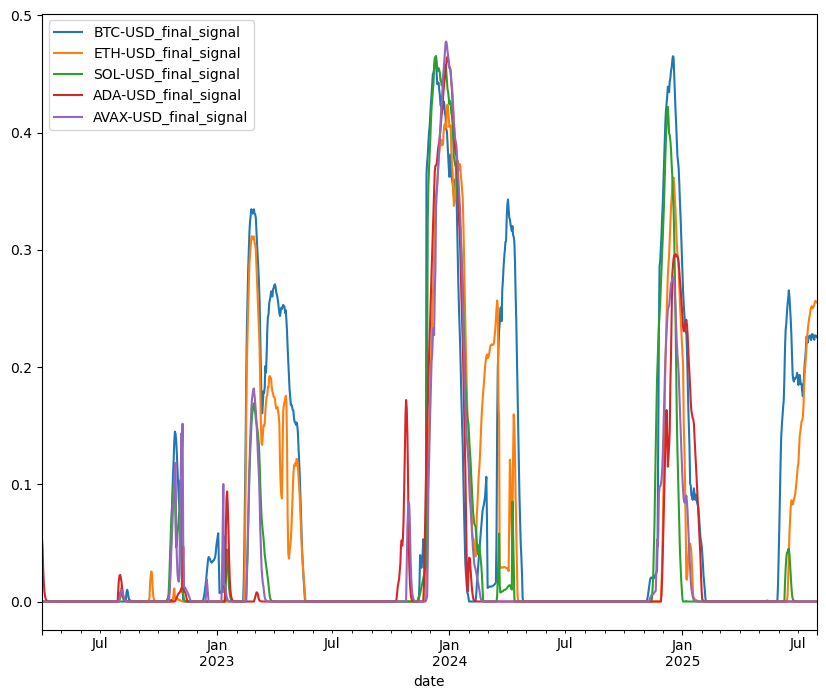

In [136]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
df_final_prod_config[final_signal_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

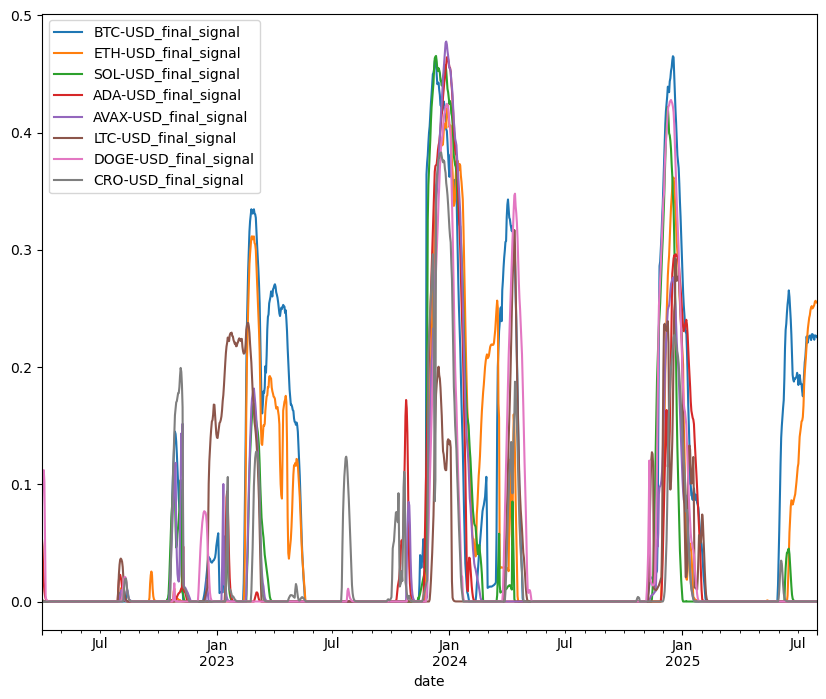

In [138]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config_expanded[final_signal_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

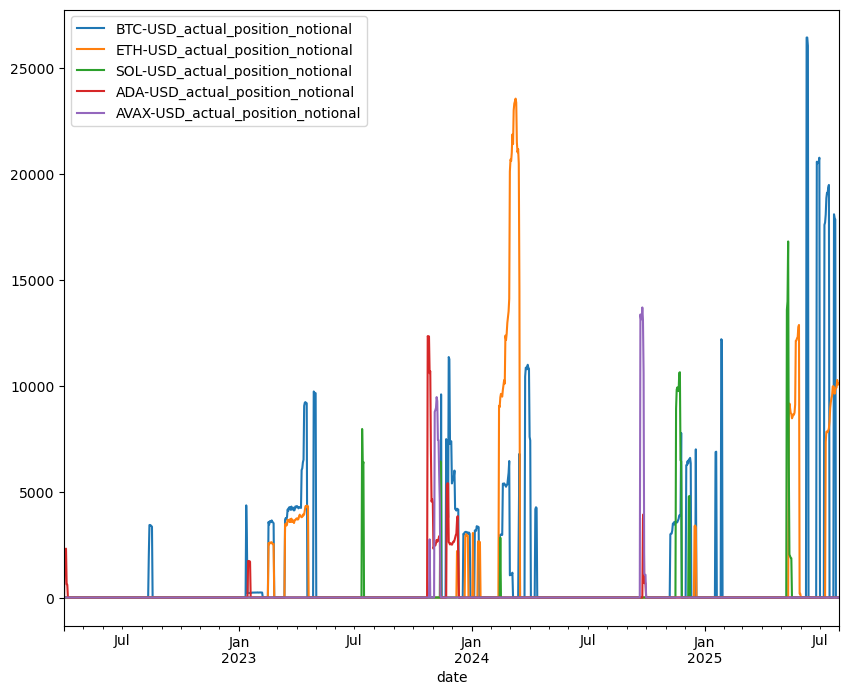

In [139]:
return_cols = [f'{ticker}_actual_position_notional' for ticker in cfg['universe']['tickers']]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

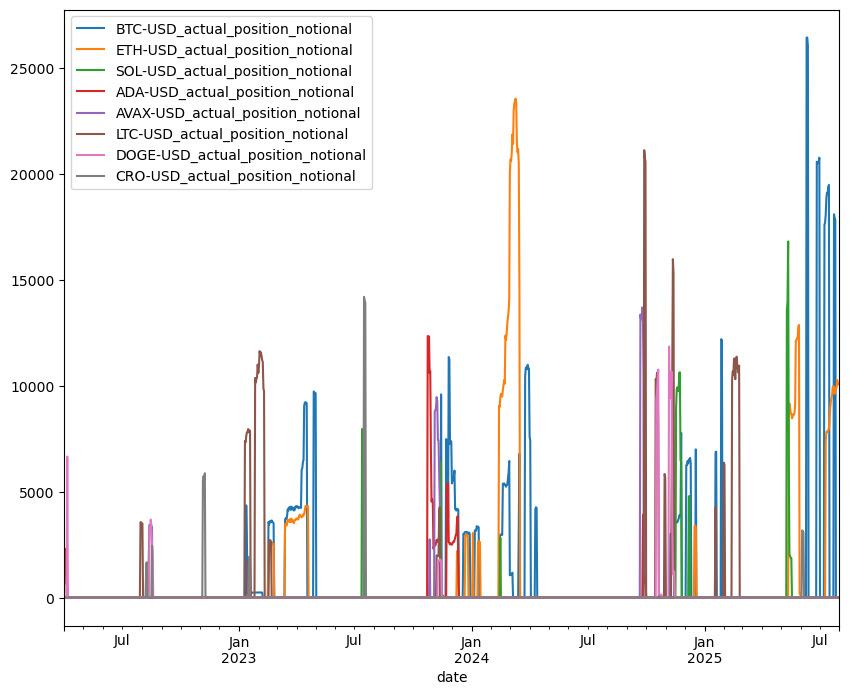

In [141]:
return_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

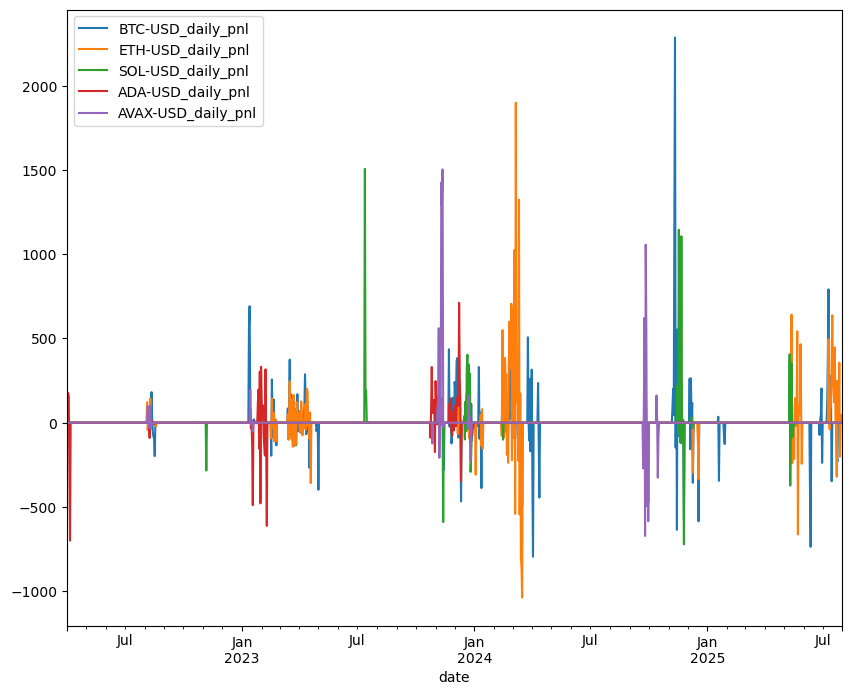

In [143]:
return_cols = [f'{ticker}_daily_pnl' for ticker in cfg['universe']['tickers']]
df_final_prod_config[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

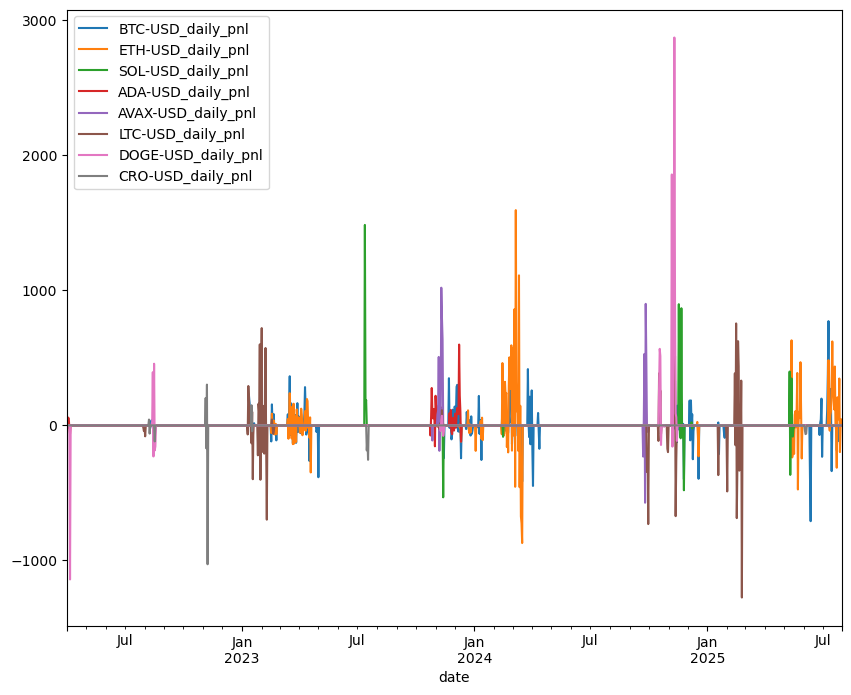

In [144]:
return_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

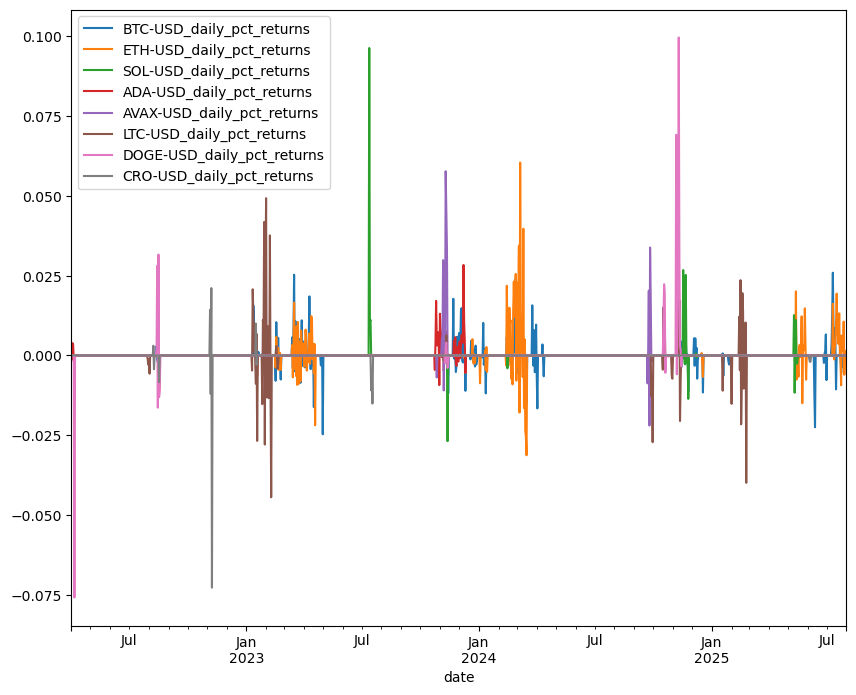

In [148]:
return_cols = [f'{ticker}_daily_pct_returns' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

## Get a list of all tradeable coins from Coinbase on any given day

In [23]:
def product_to_dict(p):
    # Pydantic v2
    fn = getattr(p, "model_dump", None)
    if callable(fn):
        return fn(exclude_none=True)  # or fn() if you want Nones

    # Pydantic v1
    fn = getattr(p, "dict", None)
    if callable(fn):
        return fn()

    # JSON fallbacks (v2 and v1 respectively)
    fn = getattr(p, "model_dump_json", None)
    if callable(fn):
        return json.loads(p.model_dump_json())
    fn = getattr(p, "json", None)
    if callable(fn):
        return json.loads(p.json())

    # Last-resort: plain object
    if hasattr(p, "__dict__"):
        return {k: v for k, v in vars(p).items() if not k.startswith("_")}

    return {"raw": str(p)}

In [25]:
## Get a snapshot of all the available coins to trade
CANON_QUOTE = "USD"
PRODUCTS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)
LIQUIDITY_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/liquidity")
LIQUIDITY_DIR.mkdir(parents=True, exist_ok=True)
ELIGIBLE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/eligible_products")
ELIGIBLE_DIR.mkdir(parents=True, exist_ok=True)

def coinbase_product_snapshot(client, asof=None, save=True):

    asof = asof or datetime.now(timezone.utc).date().isoformat()
    prod = client.get_products()['products']
    rows = [product_to_dict(p) for p in prod]
    df = pd.json_normalize(rows)

    # optional: keep only columns you care about
    reqd_cols = [
        "product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
        "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
    ]
    df = df[reqd_cols]

    # optional: coerce numerics
    num_cols = ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
                "price","approximate_quote_24h_volume"]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"]) &
        (~df["is_disabled"]) &
        (~df["view_only"]) &
        (~df["cancel_only"]) &
        (~df["auction_mode"])
    )
    df = df[filt]

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}_prod.parquet"
        df.to_parquet(out, index=False)

    return df

In [27]:
def products_diff(prev_path, curr_path):
    
    prev = pd.read_parquet(prev_path)
    curr = pd.read_parquet(curr_path)
    prev_set = set(prev["ticker"])
    curr_set = set(curr["ticker"])
    adds = sorted(list(curr_set - prev_set))
    drops = sorted(list(prev_set - curr_set))
    
    return {"adds": adds, "drops": drops}

In [29]:
## Get OHLC data for each coin
def get_coinbase_candle_data(client, product_id, start_date, end_date):
    """Return a daily OHLCV DataFrame indexed by date. Empty DF if no data."""

    start_date = pd.Timestamp(start_date)
    end_date   = pd.Timestamp(end_date)
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity='ONE_DAY',
    )
    candles = resp.candles or []

    if not candles:
        # return an empty frame with the expected schema
        cols = ['low','high','open','close','volume']
        return pd.DataFrame(columns=cols).astype({c:'float64' for c in cols})

    rows = [{
        'date':   c['start'],
        'low':    float(c['low']),
        'high':   float(c['high']),
        'open':   float(c['open']),
        'close':  float(c['close']),
        'volume': float(c['volume']),
    } for c in candles]

    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(pd.to_numeric(df['date'], errors='coerce'), unit='s', utc=True).dt.date
    return df.sort_values('date').set_index('date')

In [31]:
## Check if enough history is available and if the liquidity metrics meet all required thresholds
def has_warmup_coverage(client, product_id: str, asof_date, warmup_days: int) -> bool:
    """
    Return True if there is at least one daily candle on or before (asof - warmup_days),
    using a tiny 1-day query window.
    """
    # asof_date can be 'YYYY-MM-DD', date, or datetime
    asof = pd.Timestamp(asof_date).date()

    # boundary day at 00:00:00 UTC
    start = asof - pd.Timedelta(days=warmup_days)
    end   = start + pd.Timedelta(days=1)
    start_timestamp = int(pd.Timestamp(start).timestamp())
    end_timestamp = int(pd.Timestamp(end).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity="ONE_DAY",   # required enum value
    )
    candles = getattr(resp, "candles", []) or []
    return bool(candles)


def get_liquidity_metrics(client, product_id, asof_date, lookback_day_count=90):
    
    end_date = pd.Timestamp(asof_date).date()
    start_date = end_date - pd.Timedelta(days=lookback_day_count)
    df = get_coinbase_candle_data(client, product_id=product_id, start_date=start_date, end_date=end_date)
    df['notional_usd'] = df['volume'] * df['close']
    df['adv_90d_median'] = df['notional_usd'].rolling(90).median()
    df['high_low_spread_bps'] = (df['high'] - df['low']) / ((df['high'] + df['low']) / 2) * 10000
    df['high_low_spread_90d_median'] = df['high_low_spread_bps'].rolling(90).median()

    return df

In [397]:
## Get liquidity metrics for all coins
def get_liquidity_metrics_all_tickers_monthly(client, product_id_list, asof_date, lookback_day_count=90, warmup_days=300, save=True):

    df_liquidity = pd.DataFrame(columns=['asof_date','product_id','adv_90d_median','high_low_spread_90d_median','warmup_days_available'])
    
    for product_id in product_id_list:
        try:
            df = get_liquidity_metrics(client, product_id, asof_date=asof_date, lookback_day_count=lookback_day_count)
            row = {
                'asof_date': asof_date,
                'product_id': product_id,
                'adv_90d_median': df.loc[pd.Timestamp(asof_date).date()]['adv_90d_median'],
                'high_low_spread_90d_median': df.loc[pd.Timestamp(asof_date).date()]['high_low_spread_90d_median'],
                'warmup_days_available': has_warmup_coverage(client, product_id=product_id, asof_date=asof_date, warmup_days=warmup_days)
            }
            df_liquidity.loc[df_liquidity.shape[0]] = row
        except KeyError:
            continue

    if save:
        out = LIQUIDITY_DIR / f"{asof_date}_liquidity.parquet"
        df_liquidity.to_parquet(out, index=False)

    return df_liquidity

## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list_monthly(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                     warmup_days_col='warmup_days_available', adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[warmup_days_col]) &
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(exclusions))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [395]:
from concurrent.futures import ThreadPoolExecutor
import time, random
import pandas as pd
import numpy as np

# ---- worker: minimal jitter + tiny retry on 429, nothing else ----
def _call_with_retry(fn, *args, **kwargs):
    for i in range(2):  # at most 2 tries
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            status = getattr(getattr(e, "response", None), "status_code", None)
            if status == 429:
                # quick backoff (200ms, then 400ms) + jitter
                time.sleep(0.2 * (2**i) + random.uniform(0.0, 0.08))
                continue
            raise
    # last attempt without catching
    return fn(*args, **kwargs)

def _one_product_liquidity(client, pid, asof_date, lookback_day_count):
    asof_key = pd.Timestamp(asof_date).date()

    # a hair of jitter so batch submissions don't land at the same millisecond
    # (very small; won't slow total runtime noticeably)
    time.sleep(random.uniform(0.0, 0.02))

    metrics = _call_with_retry(
        get_liquidity_metrics,
        client=client, product_id=pid, asof_date=asof_key, lookback_day_count=lookback_day_count
    )
    if metrics is None or metrics.empty:
        return None

    if asof_key not in metrics.index:
        metrics = metrics.loc[:asof_key]
        if metrics.empty:
            return None

    row = metrics.iloc[-1]
    adv = row.get("adv_90d_median", np.nan)
    hls = row.get("high_low_spread_90d_median", np.nan)
    if not np.isfinite(adv) or not np.isfinite(hls):
        return None

    return {
        "asof_date": asof_key,
        "product_id": pid,
        "adv_90d_median": float(adv),
        "high_low_spread_90d_median": float(hls),
    }

# ---- simple batched submit: keeps it fast but smooth ----
def _batched(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

def get_liquidity_metrics_all_tickers_daily_fast(
    client, product_id_list, asof_date,
    lookback_day_count=90, 
    max_workers=12, batch_size=16, between_batches_sleep=0.10, save=True
):
    STABLECOINS = {'USDC-USD','DAI-USD','USDT-USD'}
    # keep simple upfront pruning
    pids = [p for p in product_id_list if p.endswith("-USD") and p not in STABLECOINS]

    rows = []

    # --- batched submission: prevents huge burst that causes 429 ---
    for batch in _batched(pids, batch_size):
        # small, short-lived pool per batch keeps scheduling overhead low
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            # Use executor.map for low overhead (faster than as_completed here)
            args_iter = ((client, pid, asof_date, lookback_day_count) for pid in batch)
            for res in ex.map(lambda a: _one_product_liquidity(*a), args_iter, chunksize=1):
                if res:
                    rows.append(res)

        # tiny pause between bursts; tune 0.05–0.15s if you still see 429s
        if between_batches_sleep:
            time.sleep(between_batches_sleep)

    df = pd.DataFrame(rows, columns=[
        "asof_date","product_id","adv_90d_median","high_low_spread_90d_median"
    ])
    # if save and len(df):
    #     out = LIQUIDITY_DIR / f"{pd.Timestamp(asof_date).date()}_liquidity.parquet"
    #     df.to_parquet(out, index=False)
    return df

## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list_daily(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                   adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    STABLECOINS = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(STABLECOINS))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [37]:
asof_date = pd.Timestamp('2025-10-24').date()
lookback_day_count = 90
warmup_days = cfg['run']['warmup_days']
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')

In [ ]:
df_products_t_1 = coinbase_product_snapshot(client, asof=pd.Timestamp('2025-10-23').date(), save=True)

In [ ]:
df_products = coinbase_product_snapshot(client, asof=asof_date, save=True)

In [ ]:
df_products.shape

In [ ]:
%%time
## Get the product snapshot, liquidity metrics and eligible ticker list on a monthly frequency from 2022-03-01 to 2025-07-31 
lookback_day_count = 90
warmup_days = 300
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-03-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
for date in date_range:
    print(date)
    df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
    curr_product_list = df_products.product_id.unique().tolist()
    df_liquidity_ticker = get_liquidity_metrics_all_tickers_monthly(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                                    lookback_day_count=lookback_day_count, warmup_days=warmup_days, save=True)
    df_eligible, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list(df=df_liquidity_ticker, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                 median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                 warmup_days_col='warmup_days_available',
                                                                                 adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)

In [393]:
%%time
## Get the product snapshot, liquidity metrics and eligible ticker list on a monthly frequency for one day
lookback_day_count = 90
warmup_days = 300
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-03-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
# for date in date_range:
date = pd.Timestamp('2025-11-03')
print(date)
df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
curr_product_list = df_products.product_id.unique().tolist()
df_liquidity_ticker_fast = get_liquidity_metrics_all_tickers_daily_fast(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                                        lookback_day_count=lookback_day_count, max_workers=5, batch_size=12, between_batches_sleep=0.10, save=False)
df_eligible_test, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list_daily(df=df_liquidity_ticker_fast, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                        median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                        adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)

2025-11-03 00:00:00
CPU times: user 3.59 s, sys: 399 ms, total: 3.99 s
Wall time: 14.3 s


In [323]:
df_eligible_test

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median
0,2025-11-03,BTC-USD,6.791285e+08,247.963553
1,2025-11-03,ETH-USD,5.826334e+08,455.310747
2,2025-11-03,XRP-USD,1.964942e+08,415.427427
3,2025-11-03,SOL-USD,2.567257e+08,552.436618
4,2025-11-03,ICP-USD,3.054048e+06,498.096810
5,2025-11-03,ADA-USD,3.630803e+07,554.125420
6,2025-11-03,DOGE-USD,6.348470e+07,609.380987
7,2025-11-03,SUI-USD,4.219817e+07,572.666775
8,2025-11-03,LINK-USD,3.789432e+07,629.925488
9,2025-11-03,HBAR-USD,2.911768e+07,531.123288


In [221]:
df_eligible.shape

(57, 5)

In [217]:
df_liquidity_ticker_fast

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median
0,2025-11-04,SOL-USD,2.622961e+08,558.822787
1,2025-11-04,ZEC-USD,1.328751e+06,1056.461511
2,2025-11-04,ETH-USD,5.842807e+08,462.946418
3,2025-11-04,SUI-USD,4.302025e+07,572.666775
4,2025-11-04,BTC-USD,6.808339e+08,251.719609
5,2025-11-04,DASH-USD,2.078042e+05,682.234511
6,2025-11-04,ADA-USD,3.677714e+07,556.663226
7,2025-11-04,ICP-USD,3.072407e+06,498.830170
8,2025-11-04,XRP-USD,2.001857e+08,418.276511
9,2025-11-04,DOGE-USD,6.403289e+07,622.325105


In [399]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

# ticker_list = list(cfg['universe']['tickers'])
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD', 'LTC-USD', 'DOGE-USD', 'CRO-USD']

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])
min_trade_notional_abs = float(cfg['execution_and_costs']['min_trade_notional_abs'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()

In [41]:
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [51]:
month_end_dates = pd.date_range(start=pd.Timestamp('2022-03-31').date(), end=pd.Timestamp('2022-12-31').date(), freq='M')
eligible_ticker_liquidity_dict = {}
for month_end in month_end_dates:
    print(month_end)
    out = ELIGIBLE_DIR / f"{pd.Timestamp(month_end).date()}_eligible.parquet"
    df_eligible = pd.read_parquet(out)
    eligible_ticker_list = df_eligible.product_id.unique().tolist()
    eligible_ticker_liquidity_dict[pd.Timestamp(month_end).date()] = eligible_ticker_list

2022-03-31 00:00:00
2022-04-30 00:00:00
2022-05-31 00:00:00
2022-06-30 00:00:00
2022-07-31 00:00:00
2022-08-31 00:00:00
2022-09-30 00:00:00
2022-10-31 00:00:00
2022-11-30 00:00:00
2022-12-31 00:00:00


In [61]:
for k, v in eligible_ticker_liquidity_dict.items():
    print(k, sorted(v))

2022-03-31 ['AAVE-USD', 'ADA-USD', 'ALGO-USD', 'ANKR-USD', 'BCH-USD', 'BTC-USD', 'COMP-USD', 'DOGE-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FIL-USD', 'ICP-USD', 'LINK-USD', 'LTC-USD', 'MANA-USD', 'MKR-USD', 'UNI-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD', 'ZEC-USD']
2022-04-30 ['AAVE-USD', 'ADA-USD', 'ALGO-USD', 'AMP-USD', 'ANKR-USD', 'ATOM-USD', 'BCH-USD', 'BTC-USD', 'COMP-USD', 'CRV-USD', 'DOGE-USD', 'DOT-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FIL-USD', 'ICP-USD', 'LINK-USD', 'LTC-USD', 'MANA-USD', 'MKR-USD', 'QNT-USD', 'SOL-USD', 'SUSHI-USD', 'UNI-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD']
2022-05-31 ['AAVE-USD', 'ACH-USD', 'ADA-USD', 'ALGO-USD', 'AMP-USD', 'ATOM-USD', 'BCH-USD', 'BTC-USD', 'COMP-USD', 'CRV-USD', 'DOGE-USD', 'DOT-USD', 'EOS-USD', 'ETC-USD', 'ETH-USD', 'FIL-USD', 'ICP-USD', 'LINK-USD', 'LTC-USD', 'MANA-USD', 'MKR-USD', 'QNT-USD', 'SOL-USD', 'UNI-USD', 'XLM-USD', 'XTZ-USD', 'YFI-USD']
2022-06-30 ['ACH-USD', 'ADA-USD', 'ALGO-USD', 'AMP-USD', 'ANKR-USD', 'ATOM-USD', 'AXS-USD', '

In [63]:
## Get Eligible Ticker List based on Liquidity Metrics and Trend Following Signal at Month-End
month_end_dates = pd.date_range(start=pd.Timestamp('2022-03-31').date(), end=pd.Timestamp('2022-12-31').date(), freq='M')
eligible_ticker_dict = {}
for month_end in month_end_dates:
    print(month_end)
    out = ELIGIBLE_DIR / f"{pd.Timestamp(month_end).date()}_eligible.parquet"
    df_eligible = pd.read_parquet(out)
    eligible_ticker_list = df_eligible.product_id.unique().tolist()
    df_trend_eligible = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=pd.Timestamp(month_end).date()-pd.Timedelta(days=warmup_days), end_date=pd.Timestamp(month_end).date() + pd.Timedelta(days=10), ticker_list=eligible_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=False, saved_file_end_date=saved_file_end_date)
    
    date_cond = (df_trend_eligible.index == pd.Timestamp(month_end))
    final_signal_cols = [f'{ticker}_final_signal' for ticker in eligible_ticker_list]
    df_raw_eligible_list = df_trend_eligible[date_cond][final_signal_cols].T.reset_index()
    df_raw_eligible_list.columns = ['ticker', 'final_signal']
    df_raw_eligible_list = df_raw_eligible_list.sort_values('final_signal', ascending=False)
    min_strength = np.quantile(df_raw_eligible_list['final_signal'], q=0.8)
    min_strength_cond = (df_raw_eligible_list['final_signal'] > min_strength)
    df_raw_eligible_list = df_raw_eligible_list[min_strength_cond]
    df_raw_eligible_list["ticker"] = df_raw_eligible_list["ticker"].str.replace(r"_final_signal$", "", regex=True)
    final_eligible_list = df_raw_eligible_list.ticker.tolist()
    eligible_ticker_dict[pd.Timestamp(month_end).date()] = final_eligible_list

2022-03-31 00:00:00
2022-04-30 00:00:00
2022-05-31 00:00:00
2022-06-30 00:00:00
2022-07-31 00:00:00
2022-08-31 00:00:00
2022-09-30 00:00:00
2022-10-31 00:00:00
2022-11-30 00:00:00
2022-12-31 00:00:00


In [65]:
for key, value in eligible_ticker_dict.items():
    print(key, sorted(value))

2022-03-31 ['ADA-USD', 'DOGE-USD', 'EOS-USD', 'FIL-USD', 'ICP-USD']
2022-04-30 ['COMP-USD', 'DOGE-USD', 'FIL-USD', 'ICP-USD', 'SUSHI-USD', 'UNI-USD']
2022-05-31 []
2022-06-30 []
2022-07-31 ['ADA-USD', 'ALGO-USD', 'AXS-USD', 'EOS-USD', 'ICP-USD', 'LTC-USD', 'XTZ-USD']
2022-08-31 ['ALGO-USD', 'AMP-USD', 'BCH-USD', 'CHZ-USD', 'ETC-USD', 'ZEC-USD']
2022-09-30 ['BAT-USD', 'ETH-USD', 'JASMY-USD', 'NMR-USD', 'SHIB-USD', 'ZEC-USD']
2022-10-31 ['AMP-USD', 'BTC-USD', 'CRO-USD', 'MANA-USD', 'XTZ-USD', 'ZRX-USD']
2022-11-30 ['BCH-USD', 'DOGE-USD', 'LTC-USD']
2022-12-31 ['AMP-USD', 'BCH-USD', 'BTC-USD', 'DASH-USD', 'FARM-USD', 'LTC-USD']


In [69]:
def clamp_to_per_asset_caps(desired_delta: pd.Series,
                            current_notional_prev: pd.Series,
                            total_portfolio_value_upper_limit: float,
                            per_asset_weight_cap: float,
                            per_asset_notional_cap: float | None) -> pd.Series:
    """
    Enforce per-asset caps by limiting *post-trade* notional to:
      min(weight_cap * TPV_upper, absolute_cap if given).
    Only constrains the *upside* (you can always reduce).
    """
    if len(desired_delta) == 0:
        return desired_delta

    # cap each asset's *final* notional (current + delta)
    weight_cap_notional = per_asset_weight_cap * float(total_portfolio_value_upper_limit)
    cap_notional = weight_cap_notional if per_asset_notional_cap is None else min(weight_cap_notional, per_asset_notional_cap)

    # current long notionals; if you allow shorting, drop the clip
    curr = current_notional_prev.fillna(0.0).clip(lower=0.0)
    target_after = (curr + desired_delta).fillna(0.0)

    # where target_after exceeds cap, cut the delta so final == cap
    over = target_after > cap_notional
    if over.any():
        desired_delta.loc[over] = cap_notional - curr.loc[over]

    return desired_delta


def enforce_freeze_on_notional_deltas(desired_delta: pd.Series,
                                      current_notional_prev: pd.Series,
                                      frozen_tickers: list[str] | None,
                                      allow_adds_on_frozen: bool) -> pd.Series:
    """
    Freeze policy:
      - If allow_adds_on_frozen=True: do nothing (you may increase frozen tickers).
      - If False: you may *not* increase frozen tickers; only flat or decrease.
    """
    if not frozen_tickers:
        return desired_delta

    if allow_adds_on_frozen:
        return desired_delta

    # block positive deltas for frozen tickers
    fz = pd.Index(frozen_tickers).intersection(desired_delta.index)
    pos = desired_delta.loc[fz] > 0
    if pos.any():
        desired_delta.loc[fz[pos]] = 0.0
    return desired_delta


In [415]:
def get_target_volatility_daily_portfolio_positions_expanded_universe(df, ticker_list, initial_capital, rolling_cov_window,
                                                                      stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                      highest_high_window, cash_buffer_percentage,
                                                                      annualized_target_volatility, transaction_cost_est=0.001,
                                                                      passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                      min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                      annual_trading_days=365, use_specific_start_date=False,
                                                                      signal_start_date=None, start_date=None, previous_month_open_positions_df=None,
                                                                      frozen_ticker_list=None,
                                                                      per_asset_weight_cap=0.25,               # e.g., max 25% of PV upper limit per asset
                                                                      per_asset_notional_cap=None,             # e.g., 5000. If None, ignore absolute cap.
                                                                      allow_adds_on_frozen=True,               # True = you can scale UP frozen tickers
                                                                      eligibility_by_date=None,                # dict[date]->set([...]) of liquidity-eligible tickers
                                                                      force_exit_if_ineligible=True            # True = immediate full exit if ineligible today
                                                                     ):

    # Ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df['cash_shrink_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date and signal_start_date is not None:
        # start_index_position = df.index.get_loc(signal_start_date)
        key = pd.Timestamp(signal_start_date).normalize()
        start_index_position = df.index.get_loc(key)
    else:
        start_index_position = 0

    ## TODO: ADD PREVIOUS MONTH OPEN POSITIONS, AVAILABLE CASH AND TOTAL PORTFOLIO VALUE HERE
    if previous_month_open_positions_df is not None:
        df.loc[start_index_position, 'available_cash'] = previous_month_open_positions_df['available_cash'].iloc[0]
        df.loc[start_index_position, 'total_portfolio_value'] = previous_month_open_positions_df['total_portfolio_value'].iloc[0]
        prev_month_open_ticker_list = [col.split('_')[0] for col in previous_month_open_positions_df.columns if '_actual_position_notional' in col]
        for ticker in prev_month_open_ticker_list:
            df.loc[start_index_position, f'{ticker}_actual_position_notional'] = previous_month_open_positions_df[f'{ticker}_actual_position_notional'].iloc[0]
            df.loc[start_index_position, f'{ticker}_actual_position_size'] = previous_month_open_positions_df[f'{ticker}_actual_position_size'].iloc[0]
    else:
        df.loc[start_index_position, 'available_cash'] = initial_capital
        df.loc[start_index_position, 'total_portfolio_value'] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df.loc[date, 'available_cash'] = df.loc[previous_date, 'available_cash']

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df.loc[previous_date, 'total_portfolio_value']
        df.loc[date, 'total_portfolio_value'] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df.loc[date, 'total_portfolio_value'] *
                                             (1 - cash_buffer_percentage))
        df.loc[date, 'total_portfolio_value_upper_limit'] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                             total_portfolio_value_upper_limit)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Build current notional *from previous_date* for the union ticker_list
        current_notional_prev = df.loc[previous_date, [f"{t}_actual_position_notional" for t in ticker_list]]
        current_notional_prev.index = [c.replace("_actual_position_notional","") for c in current_notional_prev.index]

        # Convert your desired_positions dict to a Series keyed by ticker -> notional delta
        desired_delta = pd.Series(
            {t: desired_positions[t]['new_trade_notional'] for t in desired_positions},
            dtype=float
        ).reindex(current_notional_prev.index).fillna(0.0)

        ## NEW (3): daily liquidity eligibility -> hard exit
        if force_exit_if_ineligible and (eligibility_by_date is not None):
            today_set = set(eligibility_by_date.get(pd.Timestamp(date).date(), ticker_list))
            drops = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) != 0.0]
            if drops:
                # Full flatten: set delta = -current_notional
                # (If you want a “reduce-only” when negative PnL, this is where you'd do it; here we just flatten.)
                desired_delta.loc[drops] = -current_notional_prev.loc[drops].astype(float)
                # optional: mark events (per-ticker columns already exist)
                for t in drops:
                    df.loc[date, f'{t}_event'] = 'liquidity_exit'
    
                # Also block *new* entries for ineligible tickers
                blocks = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) == 0.0]
                if blocks:
                    desired_delta.loc[blocks] = 0.0
        
        ## NEW (2): freeze policy now *allows* adds if you wish
        desired_delta = enforce_freeze_on_notional_deltas(
            desired_delta, current_notional_prev,
            frozen_tickers=frozen_ticker_list,
            allow_adds_on_frozen=allow_adds_on_frozen
        )

        ## NEW (1): apply per-asset caps to post-trade notionals
        desired_delta = clamp_to_per_asset_caps(
            desired_delta=desired_delta,
            current_notional_prev=current_notional_prev,
            total_portfolio_value_upper_limit=total_portfolio_value_upper_limit,
            per_asset_weight_cap=per_asset_weight_cap,
            per_asset_notional_cap=per_asset_notional_cap
        )
        
        ## Write back to your dict structure (if your downstream expects the nested dict)
        for t in desired_positions:
            desired_positions[t]['new_trade_notional'] = float(desired_delta.get(t, 0.0))

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [83]:
df_trend_eligible.index[25]

Timestamp('2022-03-31 00:00:00')

In [89]:
set(eligible_ticker_dict.get(pd.Timestamp(df_trend_eligible.index[25]).date(), ticker_list))

{'ADA-USD', 'DOGE-USD', 'EOS-USD', 'FIL-USD', 'ICP-USD'}

In [73]:
eligible_ticker_dict

{datetime.date(2022, 3, 31): ['ICP-USD',
  'DOGE-USD',
  'EOS-USD',
  'ADA-USD',
  'FIL-USD'],
 datetime.date(2022, 4, 30): ['SUSHI-USD',
  'ICP-USD',
  'UNI-USD',
  'DOGE-USD',
  'FIL-USD',
  'COMP-USD'],
 datetime.date(2022, 5, 31): [],
 datetime.date(2022, 6, 30): [],
 datetime.date(2022, 7, 31): ['ALGO-USD',
  'ICP-USD',
  'AXS-USD',
  'XTZ-USD',
  'EOS-USD',
  'ADA-USD',
  'LTC-USD'],
 datetime.date(2022, 8, 31): ['AMP-USD',
  'CHZ-USD',
  'ETC-USD',
  'ZEC-USD',
  'BCH-USD',
  'ALGO-USD'],
 datetime.date(2022, 9, 30): ['BAT-USD',
  'JASMY-USD',
  'SHIB-USD',
  'ETH-USD',
  'NMR-USD',
  'ZEC-USD'],
 datetime.date(2022, 10, 31): ['AMP-USD',
  'CRO-USD',
  'BTC-USD',
  'XTZ-USD',
  'MANA-USD',
  'ZRX-USD'],
 datetime.date(2022, 11, 30): ['BCH-USD', 'DOGE-USD', 'LTC-USD'],
 datetime.date(2022, 12, 31): ['AMP-USD',
  'LTC-USD',
  'BTC-USD',
  'FARM-USD',
  'DASH-USD',
  'BCH-USD']}

In [355]:
def _prune_usd_products(df_products):
    cols = set(df_products.columns)
    filt = (df_products["quote_currency"] == "USD") if "quote_currency" in cols else True
    if "status" in cols:           filt &= (df_products["status"] == "online")
    if "trading_disabled" in cols: filt &= (~df_products["trading_disabled"])
    if "cancel_only" in cols:      filt &= (~df_products["cancel_only"])
    if "limit_only" in cols:       filt &= (~df_products["limit_only"])
    if "post_only" in cols:        filt &= (~df_products["post_only"])
    if "auction_mode" in cols:     filt &= (~df_products["auction_mode"])
    df = df_products.loc[filt].copy()
    stables = {"USDC-USD","USDT-USD","DAI-USD"}
    return [p for p in df["product_id"].unique().tolist() if p.endswith("-USD") and p not in stables]

def build_eligibility_by_date_for_month(
    client,
    month_start_date, month_end_date,
    lookback_day_count=90,          # your current default
    adv_quantile=0.60, high_low_quantile=0.60,
    max_workers=8, batch_size=16, between_batches_sleep=0.10
):
    """
    Returns dict[date -> set(product_id)] for every calendar day in [month_start_date, month_end_date].
    """
    ms = pd.Timestamp(month_start_date).date()
    me = pd.Timestamp(month_end_date).date()

    # 1) snapshot once at month-start and prune
    df_products = coinbase_product_snapshot(client, asof=ms, save=True)
    curr_product_list = _prune_usd_products(df_products)

    elig_by_date = {}

    # 2) daily scan across the month using the same pid list
    for d in pd.date_range(ms, me, freq="D").date:
        print(d)
        df_liq = get_liquidity_metrics_all_tickers_daily_fast(
            client, product_id_list=curr_product_list, asof_date=d,
            lookback_day_count=lookback_day_count,
            max_workers=max_workers, batch_size=batch_size,
            between_batches_sleep=between_batches_sleep, save=False
        )
        # compute daily eligibility thresholds and list
        df_eligible, adv_floor, spread_floor = get_eligible_ticker_list(
            df=df_liq, asof_date=d,
            median_adv_col='adv_90d_median',
            median_high_low_spread_col='high_low_spread_90d_median',
            warmup_days_col='warmup_days_available',     # kept for signature; your filter ignores it now
            adv_quantile_threshold=adv_quantile,
            high_low_quantile_threshold=high_low_quantile,
            save=False
        )
        elig_by_date[d] = set(df_eligible["product_id"].tolist())

    return elig_by_date


In [417]:
MONTH_END_OPEN_POSITION_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/prev_month_open_positions")
MONTH_END_OPEN_POSITION_DIR.mkdir(parents=True, exist_ok=True)
month_end_dates = pd.date_range(start=pd.Timestamp('2022-03-31').date(), end=pd.Timestamp('2022-04-30').date(), freq='M')
prev_month_open_ticker_list = []

## Loop through all month-end dates
for prev_month_end in month_end_dates:
    ## Pull in the final ticker list for the month based on the signal strength
    print('Get Final Ticker List Based on Signal Strength on Last Month End Date!!')
    final_month_ticker_list = eligible_ticker_dict[prev_month_end.date()]

    ## Set the start and end date based on the following months
    month_start_date = prev_month_end.date() + pd.Timedelta(days=1)
    month_end_date = (prev_month_end + pd.offsets.MonthEnd(1)).date()
    print(month_start_date, month_end_date, final_month_ticker_list)

    ## Pull in the available cash, total portfolio value and any open positions from the previous month
    print('Check if there are any open positions from prior month!!')
    prev_month_open_positions = MONTH_END_OPEN_POSITION_DIR / f'{prev_month_end}_open_positions.pickle'
    previous_month_open_positions_df = None
    if prev_month_open_positions.exists():
        previous_month_open_positions_df = pd.read_pickle(prev_month_open_positions)
        prev_month_available_cash = previous_month_open_positions_df.loc[prev_month_end, 'available_cash']
        prev_month_total_portfolio_value = previous_month_open_positions_df.loc[prev_month_end, 'total_portfolio_value']
        prev_month_open_ticker_list = [col.split('_')[0] for col in previous_month_open_positions_df.columns if '_actual_position_notional' in col]
        print(f'Tickers with Open Positions at Prior Month-end: {prev_month_open_ticker_list}')
    else:
        prev_month_open_ticker_list = []
        prev_month_available_cash = cfg['run']['initial_capital']
        prev_month_total_portfolio_value = cfg['run']['initial_capital']
        print('No Open Positions at Prior Month-end!!')

    ## Account for any tickers with open positions that are no longer on the final ticker list
    print('Create Final Ticker List and Frozen Ticker List!!')
    frozen_ticker_list = [ticker for ticker in prev_month_open_ticker_list if ticker not in final_month_ticker_list]
    final_month_ticker_list = final_month_ticker_list + frozen_ticker_list
    print(f'Final Ticker List for Current Month: {final_month_ticker_list}')

    # ---- NEW: build daily eligibility map (ADV/spread only) ----
    print('Pull all eligible tickers based on Liquidity Metrics for every date in the current month!!')
    eligibility_by_date = build_eligibility_by_date_for_month(
        client,
        month_start_date=month_start_date,
        month_end_date=month_end_date,
        lookback_day_count=lookback_day_count,
        adv_quantile=adv_quantile, high_low_quantile=high_low_quantile,
        max_workers=5, batch_size=12, between_batches_sleep=0.10
    )
    # -----------------------------------------------------------

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers including tickers on the frozen list
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=month_start_date - pd.Timedelta(days=warmup_days), end_date=month_end_date, ticker_list=final_month_ticker_list,
        fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=False, saved_file_end_date=saved_file_end_date)
    
    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df=df_trend, ticker_list=final_month_ticker_list,
                                                                          volatility_window=volatility_window,
                                                                          annual_trading_days=annual_trading_days)
    
    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=month_start_date - pd.Timedelta(days=warmup_days), end_date=month_end_date,
                                                        ticker_list=final_month_ticker_list, rolling_atr_window=rolling_atr_window,
                                                        highest_high_window=highest_high_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=False,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = get_target_volatility_daily_portfolio_positions_expanded_universe(
        df_signal, ticker_list=final_month_ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        start_date=month_start_date, previous_month_open_positions_df=previous_month_open_positions_df,
        frozen_ticker_list=frozen_ticker_list, 
        per_asset_weight_cap=0.25,               # e.g., max 25% of PV upper limit per asset
        per_asset_notional_cap=None,             # e.g., 5000. If None, ignore absolute cap.
        allow_adds_on_frozen=True,               # True = you can scale UP frozen tickers
        eligibility_by_date=eligibility_by_date,                # dict[date]->set([...]) of liquidity-eligible tickers
        force_exit_if_ineligible=True            # True = immediate full exit if ineligible today
    )

    ## Save month end positions as a pickle file
    actual_position_notional_cols = [col for col in df.columns if '_actual_position_notional' in col]
    actual_position_size_cols = [col for col in df.columns if '_actual_position_size' in col]
    open_position_size_list = []
    for ticker in final_month_ticker_list:
        if df.loc[pd.Timestamp(month_end_date), f'{ticker}_actual_position_size'] > 0:
            open_position_size_list.append(ticker)
    
    ## Create month-end dataframe to archive for following month
    prev_month_cols = ['date', 'available_cash', 'total_portfolio_value']
    open_position_size_cols = [f'{ticker}_actual_position_size' for ticker in open_position_size_list]
    open_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in open_position_size_list]
    prev_month_cols = prev_month_cols + open_position_size_cols + open_position_notional_cols
    df_month_end_positions = pd.DataFrame(columns=prev_month_cols)
    df_month_end_positions.loc[0, 'date'] = pd.Timestamp(month_end_date)
    df_month_end_positions = df_month_end_positions.set_index('date')
    df_month_end_positions.loc[pd.Timestamp(month_end_date), 'available_cash'] = df.loc[pd.Timestamp(month_end_date), 'available_cash']
    df_month_end_positions.loc[pd.Timestamp(month_end_date), 'total_portfolio_value'] = df.loc[pd.Timestamp(month_end_date), 'total_portfolio_value']
    for ticker in open_position_size_list:
        df_month_end_positions.loc[pd.Timestamp(month_end_date), f'{ticker}_actual_position_notional'] = df.loc[pd.Timestamp(month_end_date), f'{ticker}_actual_position_notional']
        df_month_end_positions.loc[pd.Timestamp(month_end_date), f'{ticker}_actual_position_size'] = df.loc[pd.Timestamp(month_end_date), f'{ticker}_actual_position_size']

    month_end_open_positions = MONTH_END_OPEN_POSITION_DIR / f'{month_end_date}_open_positions.pickle'
    df_month_end_positions.to_pickle(month_end_open_positions)

Get Final Ticker List Based on Signal Strength on Last Month End Date!!
2022-04-01 2022-04-30 ['ICP-USD', 'DOGE-USD', 'EOS-USD', 'ADA-USD', 'FIL-USD']
Check if there are any open positions from prior month!!
No Open Positions at Prior Month-end!!
Create Final Ticker List and Frozen Ticker List!!
Final Ticker List for Current Month: ['ICP-USD', 'DOGE-USD', 'EOS-USD', 'ADA-USD', 'FIL-USD']
Pull all eligible tickers based on Liquidity Metrics for every date in the current month!!
2022-04-01
2022-04-02
2022-04-03
2022-04-04
2022-04-05
2022-04-06
2022-04-07
2022-04-08
2022-04-09
2022-04-10
2022-04-11
2022-04-12
2022-04-13
2022-04-14
2022-04-15
2022-04-16
2022-04-17
2022-04-18
2022-04-19
2022-04-20
2022-04-21
2022-04-22
2022-04-23
2022-04-24
2022-04-25
2022-04-26
2022-04-27
2022-04-28
2022-04-29
2022-04-30
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
DOGE-USD
EOS-USD
ADA-USD
FIL-USD
Calc

ValueError: Date 269 not found in DataFrame or covariance matrix index.

In [423]:
df = get_target_volatility_daily_portfolio_positions_expanded_universe(
        df_signal, ticker_list=final_month_ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
        use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date,
        start_date=month_start_date, previous_month_open_positions_df=previous_month_open_positions_df,
        frozen_ticker_list=frozen_ticker_list, 
        per_asset_weight_cap=0.25,               # e.g., max 25% of PV upper limit per asset
        per_asset_notional_cap=None,             # e.g., 5000. If None, ignore absolute cap.
        allow_adds_on_frozen=True,               # True = you can scale UP frozen tickers
        eligibility_by_date=eligibility_by_date,                # dict[date]->set([...]) of liquidity-eligible tickers
        force_exit_if_ineligible=True            # True = immediate full exit if ineligible today
    )

ValueError: Date 269 not found in DataFrame or covariance matrix index.

In [425]:
month_start_date

datetime.date(2022, 4, 1)

In [427]:
signal_start_date

datetime.date(2022, 4, 1)

In [429]:
use_specific_start_date

True

In [421]:
df_signal.head()

,ICP-USD_close,ICP-USD_open,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_annualized_volatility_30,ICP-USD_vol_adjusted_trend_signal,DOGE-USD_close,DOGE-USD_open,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_annualized_volatility_30,DOGE-USD_vol_adjusted_trend_signal,EOS-USD_close,EOS-USD_open,EOS-USD_t_1_close,EOS-USD_t_1_close_pct_returns,EOS-USD_final_signal,EOS-USD_final_weighted_additive_signal,EOS-USD_annualized_volatility_30,EOS-USD_vol_adjusted_trend_signal,ADA-USD_close,ADA-USD_open,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_annualized_volatility_30,ADA-USD_vol_adjusted_trend_signal,FIL-USD_close,FIL-USD_open,FIL-USD_t_1_close,FIL-USD_t_1_close_pct_returns,FIL-USD_final_signal,FIL-USD_final_weighted_additive_signal,FIL-USD_annualized_volatility_30,FIL-USD_vol_adjusted_trend_signal,ICP-USD_20_avg_true_range_price,ICP-USD_highest_high_56,ICP-USD_lowest_low_56,DOGE-USD_20_avg_true_range_price,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,EOS-USD_20_avg_true_range_price,EOS-USD_highest_high_56,EOS-USD_lowest_low_56,ADA-USD_20_avg_true_range_price,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,FIL-USD_20_avg_true_range_price,FIL-USD_highest_high_56,FIL-USD_lowest_low_56
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-05,104.663,108.779,NaN,NaN,NaN,NaN,NaN,0.0,0.3718,0.3769,NaN,NaN,NaN,NaN,NaN,0.0,5.778,6.022,NaN,NaN,NaN,NaN,NaN,0.0,1.6570,1.7087,NaN,NaN,NaN,NaN,NaN,0.0,88.1400,88.0410,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-06,104.424,104.511,104.663,NaN,NaN,NaN,NaN,0.0,0.3717,0.3718,0.3718,NaN,NaN,NaN,NaN,0.0,5.848,5.774,5.778,NaN,NaN,NaN,NaN,0.0,1.6778,1.6562,1.6570,NaN,NaN,NaN,NaN,0.0,87.0008,88.0976,88.1400,NaN,NaN,NaN,NaN,0.0,16.099000,NaN,NaN,0.035000,NaN,NaN,0.581000,NaN,NaN,0.183000,NaN,NaN,7.225800,NaN,NaN
2021-06-07,91.380,104.431,104.424,-0.002284,NaN,NaN,NaN,0.0,0.3315,0.3719,0.3717,-0.000269,NaN,NaN,NaN,0.0,5.193,5.848,5.848,0.012115,NaN,NaN,NaN,0.0,1.5665,1.6778,1.6778,0.012553,NaN,NaN,NaN,0.0,82.0347,87.0901,87.0008,-0.012925,NaN,NaN,NaN,0.0,15.269381,NaN,NaN,0.032667,NaN,NaN,0.548143,NaN,NaN,0.171429,NaN,NaN,6.827838,NaN,NaN
2021-06-08,81.421,91.321,91.380,-0.124914,NaN,NaN,NaN,0.0,0.3264,0.3317,0.3315,-0.108152,NaN,NaN,NaN,0.0,5.054,5.189,5.193,-0.112004,NaN,NaN,NaN,0.0,1.5842,1.5665,1.5665,-0.066337,NaN,NaN,NaN,0.0,76.0441,82.0300,82.0347,-0.057081,NaN,NaN,NaN,0.0,15.517916,NaN,NaN,0.034565,NaN,NaN,0.579939,NaN,NaN,0.173531,NaN,NaN,7.329415,NaN,NaN
2021-06-09,81.503,81.401,81.421,-0.108984,NaN,NaN,NaN,0.0,0.3436,0.3264,0.3264,-0.015385,NaN,NaN,NaN,0.0,5.342,5.052,5.054,-0.026767,NaN,NaN,NaN,0.0,1.6279,1.5837,1.5842,0.011299,NaN,NaN,NaN,0.0,77.7800,76.0270,76.0441,-0.073025,NaN,NaN,NaN,0.0,15.735162,NaN,NaN,0.035683,NaN,NaN,0.596802,NaN,NaN,0.175794,NaN,NaN,7.890014,NaN,NaN


In [419]:
eligibility_by_date

{datetime.date(2022, 4, 1): {'AAVE-USD',
  'ACH-USD',
  'ADA-USD',
  'ALGO-USD',
  'AMP-USD',
  'ANKR-USD',
  'AXS-USD',
  'BCH-USD',
  'BTC-USD',
  'COMP-USD',
  'CRO-USD',
  'DOGE-USD',
  'DOT-USD',
  'EOS-USD',
  'ETC-USD',
  'ETH-USD',
  'FIL-USD',
  'ICP-USD',
  'LINK-USD',
  'LTC-USD',
  'MANA-USD',
  'MKR-USD',
  'SHIB-USD',
  'SOL-USD',
  'UNI-USD',
  'XLM-USD',
  'XTZ-USD',
  'YFI-USD',
  'ZEC-USD'},
 datetime.date(2022, 4, 2): {'AAVE-USD',
  'ACH-USD',
  'ADA-USD',
  'ALGO-USD',
  'AMP-USD',
  'ANKR-USD',
  'AXS-USD',
  'BCH-USD',
  'BTC-USD',
  'COMP-USD',
  'CRO-USD',
  'DOGE-USD',
  'DOT-USD',
  'EOS-USD',
  'ETC-USD',
  'ETH-USD',
  'FIL-USD',
  'ICP-USD',
  'LINK-USD',
  'LTC-USD',
  'MANA-USD',
  'MKR-USD',
  'SHIB-USD',
  'SOL-USD',
  'UNI-USD',
  'XLM-USD',
  'XTZ-USD',
  'YFI-USD',
  'ZEC-USD'},
 datetime.date(2022, 4, 3): {'AAVE-USD',
  'ACH-USD',
  'ADA-USD',
  'ALGO-USD',
  'AMP-USD',
  'ANKR-USD',
  'AXS-USD',
  'BCH-USD',
  'BTC-USD',
  'COMP-USD',
  'CRO-USD',


In [181]:
df_trend.head()

,BTC-USD_close,BTC-USD_open,BTC-USD_mavg_ribbon_slope,BTC-USD_mavg_ribbon_rank,BTC-USD_final_weighted_additive_signal,BTC-USD_rolling_r_sqr,BTC-USD_final_signal,ETH-USD_close,ETH-USD_open,ETH-USD_mavg_ribbon_slope,ETH-USD_mavg_ribbon_rank,ETH-USD_final_weighted_additive_signal,ETH-USD_rolling_r_sqr,ETH-USD_final_signal,SOL-USD_close,SOL-USD_open,SOL-USD_mavg_ribbon_slope,SOL-USD_mavg_ribbon_rank,SOL-USD_final_weighted_additive_signal,SOL-USD_rolling_r_sqr,SOL-USD_final_signal,ADA-USD_close,ADA-USD_open,ADA-USD_mavg_ribbon_slope,ADA-USD_mavg_ribbon_rank,ADA-USD_final_weighted_additive_signal,ADA-USD_rolling_r_sqr,ADA-USD_final_signal,AVAX-USD_close,AVAX-USD_open,AVAX-USD_mavg_ribbon_slope,AVAX-USD_mavg_ribbon_rank,AVAX-USD_final_weighted_additive_signal,AVAX-USD_rolling_r_sqr,AVAX-USD_final_signal,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_t_1_close_volatility_30,BTC-USD_annualized_volatility_30,BTC-USD_vol_adjusted_trend_signal,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_t_1_close_volatility_30,ETH-USD_annualized_volatility_30,ETH-USD_vol_adjusted_trend_signal,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_t_1_close_volatility_30,SOL-USD_annualized_volatility_30,SOL-USD_vol_adjusted_trend_signal,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_t_1_close_volatility_30,ADA-USD_annualized_volatility_30,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_t_1_close_volatility_30,AVAX-USD_annualized_volatility_30,AVAX-USD_vol_adjusted_trend_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-05,35539.49,36856.53,NaN,NaN,NaN,NaN,NaN,2629.75,2691.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6570,1.7087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2021-06-06,35800.48,35539.97,-1.505502e-14,NaN,NaN,NaN,NaN,2710.97,2629.45,-1.041377e-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6778,1.6562,-7.019502e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35539.49,NaN,NaN,NaN,0.0,2629.75,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.6570,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2021-06-07,33575.91,35800.48,2.586511e-04,NaN,NaN,NaN,NaN,2592.47,2710.97,1.075271e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5665,1.6778,4.409818e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35800.48,0.007344,NaN,NaN,0.0,2710.97,0.030885,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.6778,0.012553,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2021-06-08,33402.13,33567.26,-1.775049e-03,NaN,NaN,NaN,NaN,2509.11,2592.47,4.684885e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5842,1.5665,-1.586315e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33575.91,-0.062138,NaN,NaN,0.0,2592.47,-0.043711,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.5665,-0.066337,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2021-06-09,37403.86,33402.13,-3.799347e-03,NaN,NaN,NaN,NaN,2611.27,2509.10,-1.236871e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6279,1.5837,-3.024335e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33402.13,-0.005176,NaN,NaN,0.0,2509.11,-0.032155,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.5842,0.011299,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0


In [357]:
month_end_dates = pd.date_range(start=pd.Timestamp('2022-03-31').date(), end=pd.Timestamp('2022-12-31').date(), freq='M')
prev_month_open_ticker_list = []

## Loop through all month-end dates
for prev_month_end in month_end_dates:
    ## Pull in the final ticker list for the month based on the signal strength
    final_month_ticker_list = eligible_ticker_dict[prev_month_end.date()]

    ## Set the start and end date based on the following months
    month_start_date = prev_month_end.date() + pd.Timedelta(days=1)
    month_end_date = (prev_month_end + pd.offsets.MonthEnd(1)).date()
    print(month_start_date, month_end_date, final_month_ticker_list)

    eligibility_by_date = build_eligibility_by_date_for_month(
            client,
            month_start_date=month_start_date,
            month_end_date=month_end_date,
            lookback_day_count=lookback_day_count,
            adv_quantile=adv_quantile, high_low_quantile=high_low_quantile,
            max_workers=5, batch_size=12, between_batches_sleep=0.10
        )

2022-04-01 2022-04-30 ['ICP-USD', 'DOGE-USD', 'EOS-USD', 'ADA-USD', 'FIL-USD']
2022-04-01
2022-04-02
2022-04-03
2022-04-04
2022-04-05
2022-04-06
2022-04-07
2022-04-08
2022-04-09
2022-04-10
2022-04-11
2022-04-12
2022-04-13
2022-04-14
2022-04-15
2022-04-16
2022-04-17
2022-04-18
2022-04-19
2022-04-20
2022-04-21
2022-04-22
2022-04-23
2022-04-24
2022-04-25
2022-04-26
2022-04-27
2022-04-28
2022-04-29
2022-04-30
2022-05-01 2022-05-31 ['SUSHI-USD', 'ICP-USD', 'UNI-USD', 'DOGE-USD', 'FIL-USD', 'COMP-USD']
2022-05-01


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x103562f20>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/crypto_prod/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [369]:
for k, v in eligibility_by_date.items():
    print(k, len(v), v)

2022-04-01 29 {'LTC-USD', 'ACH-USD', 'AMP-USD', 'ICP-USD', 'ETH-USD', 'AXS-USD', 'MANA-USD', 'ADA-USD', 'BTC-USD', 'ALGO-USD', 'SHIB-USD', 'UNI-USD', 'FIL-USD', 'ANKR-USD', 'EOS-USD', 'MKR-USD', 'LINK-USD', 'CRO-USD', 'ETC-USD', 'BCH-USD', 'ZEC-USD', 'AAVE-USD', 'XTZ-USD', 'DOT-USD', 'DOGE-USD', 'XLM-USD', 'SOL-USD', 'COMP-USD', 'YFI-USD'}
2022-04-02 29 {'LTC-USD', 'ACH-USD', 'AMP-USD', 'ICP-USD', 'ETH-USD', 'AXS-USD', 'MANA-USD', 'ADA-USD', 'BTC-USD', 'ALGO-USD', 'SHIB-USD', 'UNI-USD', 'FIL-USD', 'ANKR-USD', 'EOS-USD', 'MKR-USD', 'LINK-USD', 'CRO-USD', 'ETC-USD', 'BCH-USD', 'ZEC-USD', 'AAVE-USD', 'XTZ-USD', 'DOT-USD', 'DOGE-USD', 'XLM-USD', 'SOL-USD', 'COMP-USD', 'YFI-USD'}
2022-04-03 29 {'LTC-USD', 'ACH-USD', 'AMP-USD', 'ICP-USD', 'ETH-USD', 'AXS-USD', 'MANA-USD', 'ADA-USD', 'BTC-USD', 'ALGO-USD', 'SHIB-USD', 'UNI-USD', 'FIL-USD', 'ANKR-USD', 'EOS-USD', 'MKR-USD', 'LINK-USD', 'CRO-USD', 'ETC-USD', 'BCH-USD', 'ZEC-USD', 'AAVE-USD', 'XTZ-USD', 'DOT-USD', 'DOGE-USD', 'XLM-USD', 'SOL-USD

In [337]:
month_ends_between(start_date='2025-01-31', end_date='2025-02-28')

DatetimeIndex(['2025-01-31', '2025-02-28'], dtype='datetime64[ns]', freq='ME')

In [660]:
eligible_ticker_dict[pd.Timestamp('2022-03-31').date()]

['ICP-USD', 'DOGE-USD', 'EOS-USD', 'ADA-USD', 'FIL-USD']

In [157]:
final_month_ticker_list

['AMP-USD', 'LTC-USD', 'BTC-USD', 'FARM-USD', 'DASH-USD', 'BCH-USD']

In [159]:
prev_month_open_ticker_list

['BCH-USD']

In [165]:
frozen_ticker_list = [ticker for ticker in prev_month_open_ticker_list if ticker not in final_month_ticker_list]

In [167]:
frozen_ticker_list

[]

In [169]:
final_month_ticker_list = final_month_ticker_list + frozen_ticker_list

In [171]:
final_month_ticker_list

['AMP-USD', 'LTC-USD', 'BTC-USD', 'FARM-USD', 'DASH-USD', 'BCH-USD']

In [63]:
df_final_1.head()

,AMP-USD_20_avg_true_range_price,AMP-USD_actual_position_notional,AMP-USD_actual_position_size,AMP-USD_annualized_volatility_30,AMP-USD_close,AMP-USD_cooldown_counter,AMP-USD_event,AMP-USD_final_signal,AMP-USD_final_weighted_additive_signal,AMP-USD_highest_high_56,AMP-USD_lowest_low_56,AMP-USD_new_position_entry_exit_price,AMP-USD_new_position_notional,AMP-USD_new_position_size,AMP-USD_open,AMP-USD_open_position_notional,AMP-USD_open_position_size,AMP-USD_short_sale_proceeds,AMP-USD_stop_loss,AMP-USD_stopout_flag,AMP-USD_t_1_close,AMP-USD_t_1_close_pct_returns,AMP-USD_target_notional,AMP-USD_target_size,AMP-USD_target_vol_normalized_weight,AMP-USD_vol_adjusted_trend_signal,LTC-USD_20_avg_true_range_price,LTC-USD_actual_position_notional,LTC-USD_actual_position_size,LTC-USD_annualized_volatility_30,LTC-USD_close,LTC-USD_cooldown_counter,LTC-USD_event,LTC-USD_final_signal,LTC-USD_final_weighted_additive_signal,LTC-USD_highest_high_56,LTC-USD_lowest_low_56,LTC-USD_new_position_entry_exit_price,LTC-USD_new_position_notional,LTC-USD_new_position_size,LTC-USD_open,LTC-USD_open_position_notional,LTC-USD_open_position_size,LTC-USD_short_sale_proceeds,LTC-USD_stop_loss,LTC-USD_stopout_flag,LTC-USD_t_1_close,LTC-USD_t_1_close_pct_returns,LTC-USD_target_notional,LTC-USD_target_size,LTC-USD_target_vol_normalized_weight,LTC-USD_vol_adjusted_trend_signal,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,FARM-USD_20_avg_true_range_price,FARM-USD_actual_position_notional,FARM-USD_actual_position_size,FARM-USD_annualized_volatility_30,FARM-USD_close,FARM-USD_cooldown_counter,FARM-USD_event,FARM-USD_final_signal,FARM-USD_final_weighted_additive_signal,FARM-USD_highest_high_56,FARM-USD_lowest_low_56,FARM-USD_new_position_entry_exit_price,FARM-USD_new_position_notional,FARM-USD_new_position_size,FARM-USD_open,FARM-USD_open_position_notional,FARM-USD_open_position_size,FARM-USD_short_sale_proceeds,FARM-USD_stop_loss,FARM-USD_stopout_flag,FARM-USD_t_1_close,FARM-USD_t_1_close_pct_returns,FARM-USD_target_notional,FARM-USD_target_size,FARM-USD_target_vol_normalized_weight,FARM-USD_vol_adjusted_trend_signal,DASH-USD_20_avg_true_range_price,DASH-USD_actual_position_notional,DASH-USD_actual_position_size,DASH-USD_annualized_volatility_30,DASH-USD_close,DASH-USD_cooldown_counter,DASH-USD_event,DASH-USD_final_signal,DASH-USD_final_weighted_additive_signal,DASH-USD_highest_high_56,DASH-USD_lowest_low_56,DASH-USD_new_position_entry_exit_price,DASH-USD_new_position_notional,DASH-USD_new_position_size,DASH-USD_open,DASH-USD_open_position_notional,DASH-USD_open_position_size,DASH-USD_short_sale_proceeds,DASH-USD_stop_loss,DASH-USD_stopout_flag,DASH-USD_t_1_close,DASH-USD_t_1_close_pct_returns,DASH-USD_target_notional,DASH-USD_target_size,DASH-USD_target_vol_normalized_weight,DASH-USD_vol_adjusted_trend_signal,BCH-USD_20_avg_true_range_price,BCH-USD_actual_position_notional,BCH-USD_actual_position_size,BCH-USD_annualized_volatility_30,BCH-USD_close,BCH-USD_cooldown_counter,BCH-USD_event,BCH-USD_final_signal,BCH-USD_final_weighted_additive_signal,BCH-USD_highest_high_56,BCH-USD_lowest_low_56,BCH-USD_new_position_entry_exit_price,BCH-USD_new_position_notional,BCH-USD_new_position_size,BCH-USD_open,BCH-USD_open_position_notional,BCH-USD_open_position_size,BCH-USD_short_sale_proceeds,BCH-USD_stop_loss,BCH-USD_stopout_flag,BCH-USD_t_1_close,BCH-US

In [67]:
final_eligible_list

['AMP-USD', 'LTC-USD', 'BTC-USD', 'FARM-USD', 'DASH-USD', 'BCH-USD']

In [115]:
actual_position_notional_cols = [col for col in df_final_1.columns if '_actual_position_notional' in col]
actual_position_size_cols = [col for col in df_final_1.columns if '_actual_position_size' in col]
open_position_size_list = []
for ticker in final_eligible_list:
    if df_final_1[f'{ticker}_actual_position_size'].loc[pd.Timestamp(end_date)] > 0:
        open_position_size_list.append(ticker)

## Create previous months dataframe
prev_month_cols = ['date', 'available_cash', 'total_portfolio_value']
open_position_size_cols = [f'{ticker}_actual_position_size' for ticker in open_position_size_list]
open_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in open_position_size_list]
prev_month_cols = prev_month_cols + open_position_size_cols + open_position_notional_cols
df_previous_month_positions = pd.DataFrame(columns=prev_month_cols)
df_previous_month_positions.loc[0, 'date'] = pd.Timestamp(end_date)
df_previous_month_positions = df_previous_month_positions.set_index('date')
df_previous_month_positions.loc[pd.Timestamp(end_date), 'available_cash'] = df_final_1.loc[pd.Timestamp(end_date), 'available_cash']
df_previous_month_positions.loc[pd.Timestamp(end_date), 'total_portfolio_value'] = df_final_1.loc[pd.Timestamp(end_date), 'total_portfolio_value']
for ticker in open_position_size_list:
    df_previous_month_positions.loc[pd.Timestamp(end_date), f'{ticker}_actual_position_notional'] = df_final_1.loc[pd.Timestamp(end_date), f'{ticker}_actual_position_notional']
    df_previous_month_positions.loc[pd.Timestamp(end_date), f'{ticker}_actual_position_size'] = df_final_1.loc[pd.Timestamp(end_date), f'{ticker}_actual_position_size']

In [101]:
df_previous_month_positions.loc[0, 'date'] = pd.Timestamp(end_date)
df_previous_month_positions = df_previous_month_positions.set_index('date')

In [117]:
df_previous_month_positions

,available_cash,total_portfolio_value,BCH-USD_actual_position_size,BCH-USD_actual_position_notional
date,,,,
2025-07-31,7513.610562,14068.403264,11.110383,6554.792702


In [187]:
df_previous_month_positions['available_cash'].iloc[0]

7513.610561820382

In [153]:
prev_month_open_ticker_list = [col.split('_')[0] for col in df_previous_month_positions.columns if '_actual_position_notional' in col]

In [155]:
prev_month_open_ticker_list

['BCH-USD']

In [107]:
df_previous_month_positions.loc[pd.Timestamp(end_date)]

available_cash                      NaN
total_portfolio_value               NaN
BCH-USD_actual_position_size        NaN
BCH-USD_actual_position_notional    NaN
Name: 2025-07-31 00:00:00, dtype: object

In [81]:
end_date

datetime.date(2025, 7, 31)

In [53]:
print('Generating Moving Average Ribbon Signal!!')
## Generate Trend Signal for all tickers

df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
    long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
    use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

print('Generating Volatility Adjusted Trend Signal!!')
## Get Volatility Adjusted Trend Signal
df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                      annual_trading_days)

print('Getting Average True Range for Stop Loss Calculation!!')
## Get Average True Range for Stop Loss Calculation
df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                    ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                    highest_high_window=highest_high_window,
                                                    price_or_returns_calc='price',
                                                    use_coinbase_data=use_coinbase_data,
                                                    use_saved_files=use_saved_files,
                                                    saved_file_end_date=saved_file_end_date)
df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD


In [55]:
df_signal.head()

,BTC-USD_close,BTC-USD_open,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_annualized_volatility_30,BTC-USD_vol_adjusted_trend_signal,ETH-USD_close,ETH-USD_open,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_annualized_volatility_30,ETH-USD_vol_adjusted_trend_signal,SOL-USD_close,SOL-USD_open,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_annualized_volatility_30,SOL-USD_vol_adjusted_trend_signal,ADA-USD_close,ADA-USD_open,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_annualized_volatility_30,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_close,AVAX-USD_open,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_annualized_volatility_30,AVAX-USD_vol_adjusted_trend_signal,BTC-USD_20_avg_true_range_price,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,ETH-USD_20_avg_true_range_price,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,SOL-USD_20_avg_true_range_price,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,ADA-USD_20_avg_true_range_price,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,AVAX-USD_20_avg_true_range_price,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-05,35539.49,36856.53,NaN,NaN,NaN,NaN,NaN,0.0,2629.75,2691.13,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.6570,1.7087,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-06,35800.48,35539.97,35539.49,NaN,NaN,NaN,NaN,0.0,2710.97,2629.45,2629.75,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.6778,1.6562,1.6570,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-07,33575.91,35800.48,35800.48,0.007344,NaN,NaN,NaN,0.0,2592.47,2710.97,2710.97,0.030885,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.5665,1.6778,1.6778,0.012553,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-08,33402.13,33567.26,33575.91,-0.062138,NaN,NaN,NaN,0.0,2509.11,2592.47,2592.47,-0.043711,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.5842,1.5665,1.5665,-0.066337,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-09,37403.86,33402.13,33402.13,-0.005176,NaN,NaN,NaN,0.0,2611.27,2509.10,2509.11,-0.032155,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.6279,1.5837,1.5842,0.011299,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
## With R2 Confirm Days = 2
df_final_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=final_eligible_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=2,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
AMP-USD
LTC-USD
BTC-USD
FARM-USD
DASH-USD
BCH-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [686]:
actual_position_notional_cols = [f'{ticker}_actual_position_notional']
actual_position_notional_cols = [f'{ticker}_actual_position_size']
df_final_1[actual_position_notional_cols].tail()

KeyError: "None of [Index(['AVAX-USD_actual_position_size'], dtype='object')] are in the [columns]"

In [678]:
df_final_1.tail()

,ICP-USD_20_avg_true_range_price,ICP-USD_actual_position_notional,ICP-USD_actual_position_size,ICP-USD_annualized_volatility_30,ICP-USD_close,ICP-USD_cooldown_counter,ICP-USD_event,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_highest_high_56,ICP-USD_lowest_low_56,ICP-USD_new_position_entry_exit_price,ICP-USD_new_position_notional,ICP-USD_new_position_size,ICP-USD_open,ICP-USD_open_position_notional,ICP-USD_open_position_size,ICP-USD_short_sale_proceeds,ICP-USD_stop_loss,ICP-USD_stopout_flag,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_target_notional,ICP-USD_target_size,ICP-USD_target_vol_normalized_weight,ICP-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,EOS-USD_20_avg_true_range_price,EOS-USD_actual_position_notional,EOS-USD_actual_position_size,EOS-USD_annualized_volatility_30,EOS-USD_close,EOS-USD_cooldown_counter,EOS-USD_event,EOS-USD_final_signal,EOS-USD_final_weighted_additive_signal,EOS-USD_highest_high_56,EOS-USD_lowest_low_56,EOS-USD_new_position_entry_exit_price,EOS-USD_new_position_notional,EOS-USD_new_position_size,EOS-USD_open,EOS-USD_open_position_notional,EOS-USD_open_position_size,EOS-USD_short_sale_proceeds,EOS-USD_stop_loss,EOS-USD_stopout_flag,EOS-USD_t_1_close,EOS-USD_t_1_close_pct_returns,EOS-USD_target_notional,EOS-USD_target_size,EOS-USD_target_vol_normalized_weight,EOS-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,FIL-USD_20_avg_true_range_price,FIL-USD_actual_position_notional,FIL-USD_actual_position_size,FIL-USD_annualized_volatility_30,FIL-USD_close,FIL-USD_cooldown_counter,FIL-USD_event,FIL-USD_final_signal,FIL-USD_final_weighted_additive_signal,FIL-USD_highest_high_56,FIL-USD_lowest_low_56,FIL-USD_new_position_entry_exit_price,FIL-USD_new_position_notional,FIL-USD_new_position_size,FIL-USD_open,FIL-USD_open_position_notional,FIL-USD_open_position_size,FIL-USD_short_sale_proceeds,FIL-USD_stop_loss,FIL-USD_stopout_flag,FIL-USD_t_1_close,FIL-USD_t_1_close_pct_returns,FIL-USD_target_notional,FIL-USD_target_size,FIL-USD_target_vol_normalized_weight,FIL-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,ICP-USD_daily_pnl,ICP-USD_daily_pct_returns,ICP-USD_position_count,DOGE-USD_daily_pnl,DOGE-USD_daily_pct_returns,DOGE-USD_position_count,EOS-USD_daily_pnl,EOS-USD_daily_pct_returns,EOS-USD_position_count,ADA-USD_daily_p

In [668]:
eligible_ticker_start_date = pd.Timestamp('2022-04-01').date() - pd.Timedelta(days=warmup_days)
eligible_ticker_end_date = pd.Timestamp('2022-04-30').date()
eligible_ticker_list = eligible_ticker_dict[pd.Timestamp('2022-03-31').date()]
df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
    start_date=eligible_ticker_start_date, end_date=eligible_ticker_end_date, ticker_list=eligible_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
    long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
    use_saved_files=False, saved_file_end_date=saved_file_end_date)

print('Generating Volatility Adjusted Trend Signal!!')
## Get Volatility Adjusted Trend Signal
df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, eligible_ticker_list, volatility_window,
                                                                      annual_trading_days)

print('Getting Average True Range for Stop Loss Calculation!!')
## Get Average True Range for Stop Loss Calculation
df_atr = size_cont.get_average_true_range_portfolio(start_date=eligible_ticker_start_date, end_date=eligible_ticker_end_date,
                                                    ticker_list=eligible_ticker_list, rolling_atr_window=rolling_atr_window,
                                                    highest_high_window=highest_high_window,
                                                    price_or_returns_calc='price',
                                                    use_coinbase_data=use_coinbase_data,
                                                    use_saved_files=False,
                                                    saved_file_end_date=saved_file_end_date)
df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
DOGE-USD
EOS-USD
ADA-USD
FIL-USD


In [670]:
df_trend.head()

,ICP-USD_close,ICP-USD_open,ICP-USD_mavg_ribbon_slope,ICP-USD_mavg_ribbon_rank,ICP-USD_final_weighted_additive_signal,ICP-USD_rolling_r_sqr,ICP-USD_final_signal,DOGE-USD_close,DOGE-USD_open,DOGE-USD_mavg_ribbon_slope,DOGE-USD_mavg_ribbon_rank,DOGE-USD_final_weighted_additive_signal,DOGE-USD_rolling_r_sqr,DOGE-USD_final_signal,EOS-USD_close,EOS-USD_open,EOS-USD_mavg_ribbon_slope,EOS-USD_mavg_ribbon_rank,EOS-USD_final_weighted_additive_signal,EOS-USD_rolling_r_sqr,EOS-USD_final_signal,ADA-USD_close,ADA-USD_open,ADA-USD_mavg_ribbon_slope,ADA-USD_mavg_ribbon_rank,ADA-USD_final_weighted_additive_signal,ADA-USD_rolling_r_sqr,ADA-USD_final_signal,FIL-USD_close,FIL-USD_open,FIL-USD_mavg_ribbon_slope,FIL-USD_mavg_ribbon_rank,FIL-USD_final_weighted_additive_signal,FIL-USD_rolling_r_sqr,FIL-USD_final_signal,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_t_1_close_volatility_30,ICP-USD_annualized_volatility_30,ICP-USD_vol_adjusted_trend_signal,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_t_1_close_volatility_30,DOGE-USD_annualized_volatility_30,DOGE-USD_vol_adjusted_trend_signal,EOS-USD_t_1_close,EOS-USD_t_1_close_pct_returns,EOS-USD_t_1_close_volatility_30,EOS-USD_annualized_volatility_30,EOS-USD_vol_adjusted_trend_signal,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_t_1_close_volatility_30,ADA-USD_annualized_volatility_30,ADA-USD_vol_adjusted_trend_signal,FIL-USD_t_1_close,FIL-USD_t_1_close_pct_returns,FIL-USD_t_1_close_volatility_30,FIL-USD_annualized_volatility_30,FIL-USD_vol_adjusted_trend_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-05,104.663,108.779,NaN,NaN,NaN,NaN,NaN,0.3718,0.3769,NaN,NaN,NaN,NaN,NaN,5.778,6.022,NaN,NaN,NaN,NaN,NaN,1.6570,1.7087,NaN,NaN,NaN,NaN,NaN,88.1400,88.0410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2021-06-06,104.424,104.511,-6.284037e-15,NaN,NaN,NaN,NaN,0.3717,0.3718,1.295475e-15,NaN,NaN,NaN,NaN,5.848,5.774,-2.326180e-15,NaN,NaN,NaN,NaN,1.6778,1.6562,-7.019502e-16,NaN,NaN,NaN,NaN,87.0008,88.0976,-6.752509e-15,NaN,NaN,NaN,NaN,104.663,NaN,NaN,NaN,0.0,0.3718,NaN,NaN,NaN,0.0,5.778,NaN,NaN,NaN,0.0,1.6570,NaN,NaN,NaN,0.0,88.1400,NaN,NaN,NaN,0.0
2021-06-07,91.380,104.431,-8.081510e-05,NaN,NaN,NaN,NaN,0.3315,0.3719,-9.509123e-06,NaN,NaN,NaN,NaN,5.193,5.848,4.256909e-04,NaN,NaN,NaN,NaN,1.5665,1.6778,4.409818e-04,NaN,NaN,NaN,NaN,82.0347,87.0901,-4.598754e-04,NaN,NaN,NaN,NaN,104.424,-0.002284,NaN,NaN,0.0,0.3717,-0.000269,NaN,NaN,0.0,5.848,0.012115,NaN,NaN,0.0,1.6778,0.012553,NaN,NaN,0.0,87.0008,-0.012925,NaN,NaN,0.0
2021-06-08,81.421,91.321,-4.870834e-03,NaN,NaN,NaN,NaN,0.3264,0.3317,-4.064270e-03,NaN,NaN,NaN,NaN,5.054,5.189,-3.388205e-03,NaN,NaN,NaN,NaN,1.5842,1.5665,-1.586315e-03,NaN,NaN,NaN,NaN,76.0441,82.0300,-2.953805e-03,NaN,NaN,NaN,NaN,91.380,-0.124914,NaN,NaN,0.0,0.3315,-0.108152,NaN,NaN,0.0,5.193,-0.112004,NaN,NaN,0.0,1.5665,-0.066337,NaN,NaN,0.0,82.0347,-0.057081,NaN,NaN,0.0
2021-06-09,81.503,81.401,-1.328530e-02,NaN,NaN,NaN,NaN,0.3436,0.3264,-8.282223e-03,NaN,NaN,NaN,NaN,5.342,5.052,-7.799520e-03,NaN,NaN,NaN,NaN,1.6279,1.5837,-3.024335e-03,NaN,NaN,NaN,NaN,77.7800,76.0270,-7.891225e-03,NaN,NaN,NaN,NaN,81.421,-0.108984,NaN,NaN,0.0,0.3264,-0.015385,NaN,NaN,0.0,5.054,-0.026767,NaN,NaN,0.0,1.5842,0.011299,NaN,NaN,0.0,76.0441,-0.073025,NaN,NaN,0.0


In [672]:
df_signal.head()

,ICP-USD_close,ICP-USD_open,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_annualized_volatility_30,ICP-USD_vol_adjusted_trend_signal,DOGE-USD_close,DOGE-USD_open,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_annualized_volatility_30,DOGE-USD_vol_adjusted_trend_signal,EOS-USD_close,EOS-USD_open,EOS-USD_t_1_close,EOS-USD_t_1_close_pct_returns,EOS-USD_final_signal,EOS-USD_final_weighted_additive_signal,EOS-USD_annualized_volatility_30,EOS-USD_vol_adjusted_trend_signal,ADA-USD_close,ADA-USD_open,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_annualized_volatility_30,ADA-USD_vol_adjusted_trend_signal,FIL-USD_close,FIL-USD_open,FIL-USD_t_1_close,FIL-USD_t_1_close_pct_returns,FIL-USD_final_signal,FIL-USD_final_weighted_additive_signal,FIL-USD_annualized_volatility_30,FIL-USD_vol_adjusted_trend_signal,ICP-USD_20_avg_true_range_price,ICP-USD_highest_high_56,ICP-USD_lowest_low_56,DOGE-USD_20_avg_true_range_price,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,EOS-USD_20_avg_true_range_price,EOS-USD_highest_high_56,EOS-USD_lowest_low_56,ADA-USD_20_avg_true_range_price,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,FIL-USD_20_avg_true_range_price,FIL-USD_highest_high_56,FIL-USD_lowest_low_56
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-05,104.663,108.779,NaN,NaN,NaN,NaN,NaN,0.0,0.3718,0.3769,NaN,NaN,NaN,NaN,NaN,0.0,5.778,6.022,NaN,NaN,NaN,NaN,NaN,0.0,1.6570,1.7087,NaN,NaN,NaN,NaN,NaN,0.0,88.1400,88.0410,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-06,104.424,104.511,104.663,NaN,NaN,NaN,NaN,0.0,0.3717,0.3718,0.3718,NaN,NaN,NaN,NaN,0.0,5.848,5.774,5.778,NaN,NaN,NaN,NaN,0.0,1.6778,1.6562,1.6570,NaN,NaN,NaN,NaN,0.0,87.0008,88.0976,88.1400,NaN,NaN,NaN,NaN,0.0,16.099000,NaN,NaN,0.035000,NaN,NaN,0.581000,NaN,NaN,0.183000,NaN,NaN,7.225800,NaN,NaN
2021-06-07,91.380,104.431,104.424,-0.002284,NaN,NaN,NaN,0.0,0.3315,0.3719,0.3717,-0.000269,NaN,NaN,NaN,0.0,5.193,5.848,5.848,0.012115,NaN,NaN,NaN,0.0,1.5665,1.6778,1.6778,0.012553,NaN,NaN,NaN,0.0,82.0347,87.0901,87.0008,-0.012925,NaN,NaN,NaN,0.0,15.269381,NaN,NaN,0.032667,NaN,NaN,0.548143,NaN,NaN,0.171429,NaN,NaN,6.827838,NaN,NaN
2021-06-08,81.421,91.321,91.380,-0.124914,NaN,NaN,NaN,0.0,0.3264,0.3317,0.3315,-0.108152,NaN,NaN,NaN,0.0,5.054,5.189,5.193,-0.112004,NaN,NaN,NaN,0.0,1.5842,1.5665,1.5665,-0.066337,NaN,NaN,NaN,0.0,76.0441,82.0300,82.0347,-0.057081,NaN,NaN,NaN,0.0,15.517916,NaN,NaN,0.034565,NaN,NaN,0.579939,NaN,NaN,0.173531,NaN,NaN,7.329415,NaN,NaN
2021-06-09,81.503,81.401,81.421,-0.108984,NaN,NaN,NaN,0.0,0.3436,0.3264,0.3264,-0.015385,NaN,NaN,NaN,0.0,5.342,5.052,5.054,-0.026767,NaN,NaN,NaN,0.0,1.6279,1.5837,1.5842,0.011299,NaN,NaN,NaN,0.0,77.7800,76.0270,76.0441,-0.073025,NaN,NaN,NaN,0.0,15.735162,NaN,NaN,0.035683,NaN,NaN,0.596802,NaN,NaN,0.175794,NaN,NaN,7.890014,NaN,NaN


In [432]:
final_eligible_list

['ICP-USD', 'DOGE-USD', 'EOS-USD', 'ADA-USD', 'FIL-USD']

In [434]:
start_date = pd.Timestamp('2022-04-01').date()
end_date = pd.Timestamp('2022-04-30').date()

In [436]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    # date_list = cn.coinbase_start_date_by_ticker_dict
    # ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(
            0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1,
                                                  0)  ## This is not entirely accurate
    return df

In [476]:
print(start_date, end_date)

2022-04-01 2022-04-30


In [478]:
## With R2 Confirm Days = 2
df_final_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=final_eligible_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=2,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_1 = df_final_1[df_final_1.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_1 = calculate_asset_level_returns(df_final_1, end_date, final_eligible_list)

portfolio_perf_metrics_1 = calculate_risk_and_performance_metrics(df_final_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                  strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
DOGE-USD
EOS-USD
ADA-USD
FIL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.0,
 'annualized_sharpe_ratio': -inf,
 'calmar_ratio': nan,
 'annualized_std_dev': nan,
 'max_drawdown': 0.0,
 'max_drawdown_duration': Timedelta('29 days 00:00:00'),
 'hit_rate': 0.0,
 't_statistic': nan,
 'p_value': nan,
 'trade_count': 0.0}

In [439]:
ticker_perf_prod_config_expanded_1 = {}
for t in final_eligible_list:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_1,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config_expanded_1[t] = _ticker_perf

In [440]:
ticker_perf_prod_config_expanded_1

{'ICP-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('29 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': nan,
  'p_value': nan,
  'trade_count': 0},
 'DOGE-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('29 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': nan,
  'p_value': nan,
  'trade_count': 0},
 'EOS-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('29 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': nan,
  'p_value': nan,
  'trade_count': 0},
 'ADA-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawd

In [674]:
df_final_1.tail()

,ICP-USD_20_avg_true_range_price,ICP-USD_actual_position_notional,ICP-USD_actual_position_size,ICP-USD_annualized_volatility_30,ICP-USD_close,ICP-USD_cooldown_counter,ICP-USD_event,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_highest_high_56,ICP-USD_lowest_low_56,ICP-USD_new_position_entry_exit_price,ICP-USD_new_position_notional,ICP-USD_new_position_size,ICP-USD_open,ICP-USD_open_position_notional,ICP-USD_open_position_size,ICP-USD_short_sale_proceeds,ICP-USD_stop_loss,ICP-USD_stopout_flag,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_target_notional,ICP-USD_target_size,ICP-USD_target_vol_normalized_weight,ICP-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,EOS-USD_20_avg_true_range_price,EOS-USD_actual_position_notional,EOS-USD_actual_position_size,EOS-USD_annualized_volatility_30,EOS-USD_close,EOS-USD_cooldown_counter,EOS-USD_event,EOS-USD_final_signal,EOS-USD_final_weighted_additive_signal,EOS-USD_highest_high_56,EOS-USD_lowest_low_56,EOS-USD_new_position_entry_exit_price,EOS-USD_new_position_notional,EOS-USD_new_position_size,EOS-USD_open,EOS-USD_open_position_notional,EOS-USD_open_position_size,EOS-USD_short_sale_proceeds,EOS-USD_stop_loss,EOS-USD_stopout_flag,EOS-USD_t_1_close,EOS-USD_t_1_close_pct_returns,EOS-USD_target_notional,EOS-USD_target_size,EOS-USD_target_vol_normalized_weight,EOS-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,FIL-USD_20_avg_true_range_price,FIL-USD_actual_position_notional,FIL-USD_actual_position_size,FIL-USD_annualized_volatility_30,FIL-USD_close,FIL-USD_cooldown_counter,FIL-USD_event,FIL-USD_final_signal,FIL-USD_final_weighted_additive_signal,FIL-USD_highest_high_56,FIL-USD_lowest_low_56,FIL-USD_new_position_entry_exit_price,FIL-USD_new_position_notional,FIL-USD_new_position_size,FIL-USD_open,FIL-USD_open_position_notional,FIL-USD_open_position_size,FIL-USD_short_sale_proceeds,FIL-USD_stop_loss,FIL-USD_stopout_flag,FIL-USD_t_1_close,FIL-USD_t_1_close_pct_returns,FIL-USD_target_notional,FIL-USD_target_size,FIL-USD_target_vol_normalized_weight,FIL-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,ICP-USD_daily_pnl,ICP-USD_daily_pct_returns,ICP-USD_position_count,DOGE-USD_daily_pnl,DOGE-USD_daily_pct_returns,DOGE-USD_position_count,EOS-USD_daily_pnl,EOS-USD_daily_pct_returns,EOS-USD_position_count,ADA-USD_daily_p

In [490]:
out = ELIGIBLE_DIR / f"2022-04-30_eligible.parquet"
df_eligible_2 = pd.read_parquet(out)

In [520]:
eligible_ticker_start_date = pd.Timestamp('2022-04-30').date()
eligible_ticker_end_date = pd.Timestamp('2022-05-31').date()

eligible_ticker_list = df_eligible_2.product_id.unique().tolist()
df_trend_eligible_2 = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
    start_date=eligible_ticker_start_date-pd.Timedelta(days=warmup_days), end_date=eligible_ticker_end_date, ticker_list=eligible_ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
    long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
    use_saved_files=False, saved_file_end_date=saved_file_end_date)

In [521]:
eligible_ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'DOGE-USD',
 'LINK-USD',
 'ADA-USD',
 'LTC-USD',
 'XLM-USD',
 'BCH-USD',
 'AAVE-USD',
 'CRV-USD',
 'DOT-USD',
 'ICP-USD',
 'UNI-USD',
 'ATOM-USD',
 'FIL-USD',
 'ETC-USD',
 'ALGO-USD',
 'QNT-USD',
 'SUSHI-USD',
 'AMP-USD',
 'MANA-USD',
 'MKR-USD',
 'COMP-USD',
 'YFI-USD',
 'XTZ-USD',
 'ANKR-USD',
 'EOS-USD']

<Axes: xlabel='date'>

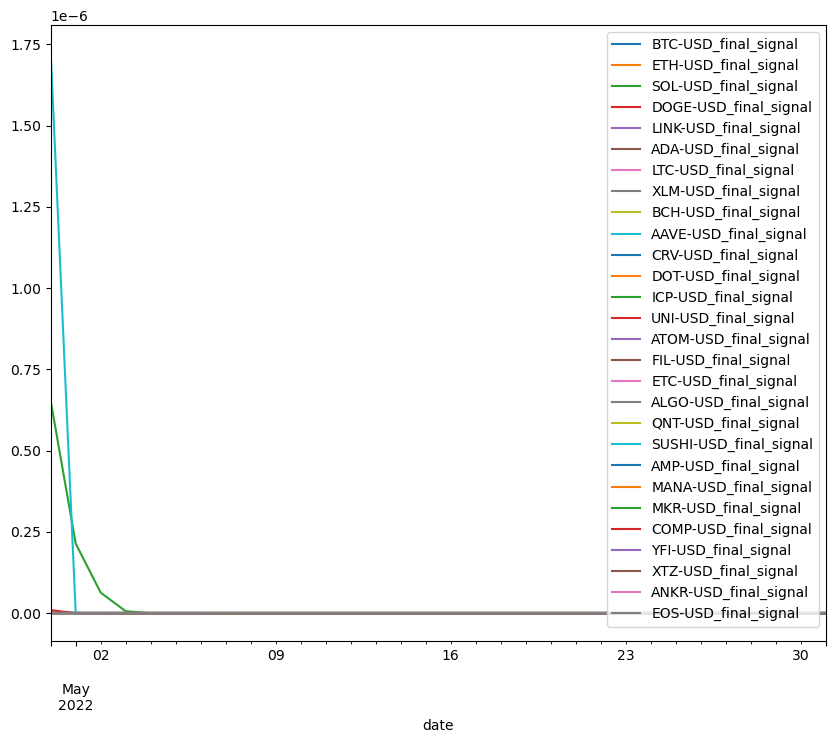

In [524]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in eligible_ticker_list]#[0:11]]
date_cond = (df_trend_eligible_2.index >= pd.Timestamp(eligible_ticker_start_date)) & (df_trend_eligible_2.index <= pd.Timestamp(eligible_ticker_end_date))
df_trend_eligible_2[date_cond][final_signal_cols].plot(figsize=(10,8))

In [526]:
print(len(eligible_ticker_list))
eligible_ticker_list

28


['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'DOGE-USD',
 'LINK-USD',
 'ADA-USD',
 'LTC-USD',
 'XLM-USD',
 'BCH-USD',
 'AAVE-USD',
 'CRV-USD',
 'DOT-USD',
 'ICP-USD',
 'UNI-USD',
 'ATOM-USD',
 'FIL-USD',
 'ETC-USD',
 'ALGO-USD',
 'QNT-USD',
 'SUSHI-USD',
 'AMP-USD',
 'MANA-USD',
 'MKR-USD',
 'COMP-USD',
 'YFI-USD',
 'XTZ-USD',
 'ANKR-USD',
 'EOS-USD']

In [530]:
date_cond = (df_trend_eligible_2.index == pd.Timestamp(eligible_ticker_start_date))
df_raw_eligible_list = df_trend_eligible_2[date_cond][final_signal_cols].T.reset_index()
df_raw_eligible_list.columns = ['ticker', 'final_signal']
df_raw_eligible_list = df_raw_eligible_list.sort_values('final_signal', ascending=False)
min_strength = np.quantile(df_raw_eligible_list['final_signal'], q=0.8)
min_strength_cond = (df_raw_eligible_list['final_signal'] > min_strength)
df_raw_eligible_list = df_raw_eligible_list[min_strength_cond]
df_raw_eligible_list["ticker"] = df_raw_eligible_list["ticker"].str.replace(r"_final_signal$", "", regex=True)
final_eligible_list_2 = df_raw_eligible_list.ticker.tolist()

In [532]:
df_raw_eligible_list

,ticker,final_signal
19,SUSHI-USD,1.722894e-06
12,ICP-USD,6.524445e-07
13,UNI-USD,9.208966e-09
3,DOGE-USD,9.148124e-10
15,FIL-USD,8.204733e-10
23,COMP-USD,2.227031e-10


<Axes: xlabel='date'>

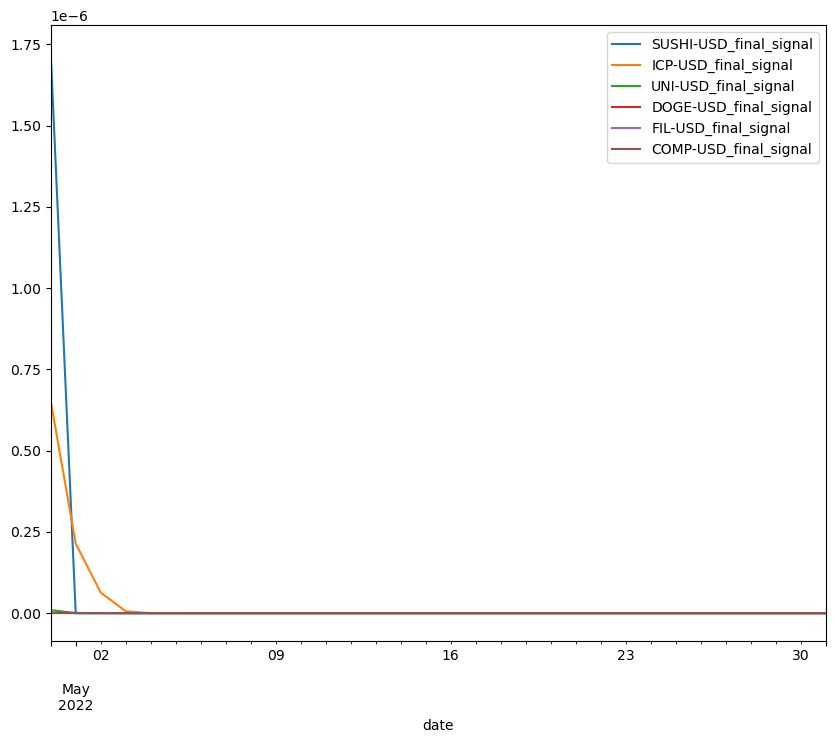

In [534]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in final_eligible_list_2]
date_cond = (df_trend_eligible_2.index >= pd.Timestamp(eligible_ticker_start_date)) & (df_trend_eligible_2.index <= pd.Timestamp(eligible_ticker_end_date))
df_trend_eligible_2[date_cond][final_signal_cols].plot(figsize=(10,8))

In [536]:
start_date = pd.Timestamp('2022-05-01').date()
end_date = pd.Timestamp('2022-05-31').date()

In [538]:
## With R2 Confirm Days = 2
df_final_2 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=final_eligible_list_2, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=2,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_2 = df_final_2[df_final_2.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_2 = calculate_asset_level_returns(df_final_2, end_date, final_eligible_list_2)

portfolio_perf_metrics_2 = calculate_risk_and_performance_metrics(df_final_2, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                  strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_2

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
SUSHI-USD
ICP-USD
UNI-USD
DOGE-USD
FIL-USD
COMP-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.0,
 'annualized_sharpe_ratio': -inf,
 'calmar_ratio': nan,
 'annualized_std_dev': nan,
 'max_drawdown': 0.0,
 'max_drawdown_duration': Timedelta('30 days 00:00:00'),
 'hit_rate': 0.0,
 't_statistic': nan,
 'p_value': nan,
 'trade_count': 0.0}

In [540]:
ticker_perf_prod_config_expanded_2 = {}
for t in final_eligible_list_2:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_2,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config_expanded_2[t] = _ticker_perf

In [542]:
ticker_perf_prod_config_expanded_2

{'SUSHI-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('30 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': nan,
  'p_value': nan,
  'trade_count': 0},
 'ICP-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('30 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': nan,
  'p_value': nan,
  'trade_count': 0},
 'UNI-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('30 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': nan,
  'p_value': nan,
  'trade_count': 0},
 'DOGE-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_dra

In [310]:
df_final_1 = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=final_eligible_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_1 = df_final_1[df_final_1.index >= pd.Timestamp(start_date)]

print('Calculating In Sample Asset Returns!!')
df_final_1 = calculate_asset_level_returns(df_final_1, end_date, final_eligible_list)

portfolio_perf_metrics_1 = calculate_risk_and_performance_metrics(df_final_1, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                  strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_1

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
ICP-USD
DOGE-USD
ADA-USD
EOS-USD
UNI-USD
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': -0.34151103947866757,
 'annualized_sharpe_ratio': -7.433420923051026,
 'calmar_ratio': -10.116625500071196,
 'annualized_std_dev': 0.10224141308648493,
 'max_drawdown': -0.03375740650637549,
 'max_drawdown_duration': Timedelta('29 days 00:00:00'),
 'hit_rate': 0.0,
 't_statistic': -1.9072156002963438,
 'p_value': 0.06644180677823817,
 'trade_count': 6.0}

In [316]:
ticker_perf_prod_config_expanded_1 = {}
for t in final_eligible_list:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_1,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config_expanded_1[t] = _ticker_perf

In [318]:
ticker_perf_prod_config_expanded_1

{'ICP-USD': {'annualized_return': -0.12686033681305398,
  'annualized_sharpe_ratio': -6.8233802798760195,
  'calmar_ratio': -11.441037476705104,
  'annualized_std_dev': 0.006808082960937974,
  'max_drawdown': -0.011088184709765359,
  'max_drawdown_duration': Timedelta('29 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': -1.437664567734575,
  'p_value': 0.1612330759426405,
  'trade_count': 2},
 'DOGE-USD': {'annualized_return': -0.2803080018200984,
  'annualized_sharpe_ratio': -4.012518202222502,
  'calmar_ratio': -10.5089304714749,
  'annualized_std_dev': nan,
  'max_drawdown': -0.026673313957205957,
  'max_drawdown_duration': Timedelta('29 days 00:00:00'),
  'hit_rate': 0.0,
  't_statistic': -1.0000000000000002,
  'p_value': 0.32558198801619365,
  'trade_count': 1},
 'ADA-USD': {'annualized_return': 0.0,
  'annualized_sharpe_ratio': -inf,
  'calmar_ratio': nan,
  'annualized_std_dev': nan,
  'max_drawdown': 0.0,
  'max_drawdown_duration': Timedelta('29 days 00:00:00'),
  'hit_rate

<Axes: xlabel='date'>

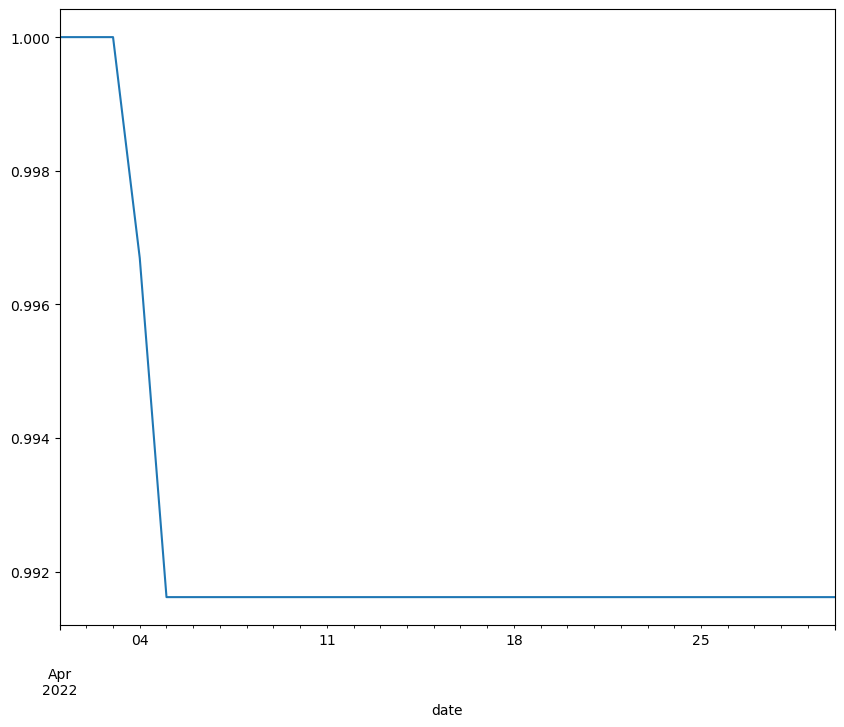

In [320]:
df_final_1['equity_curve'].plot(figsize=(10,8))

In [312]:
df_final_1.head(20)

,ICP-USD_20_avg_true_range_price,ICP-USD_actual_position_notional,ICP-USD_actual_position_size,ICP-USD_annualized_volatility_30,ICP-USD_close,ICP-USD_cooldown_counter,ICP-USD_event,ICP-USD_final_signal,ICP-USD_final_weighted_additive_signal,ICP-USD_highest_high_56,ICP-USD_lowest_low_56,ICP-USD_new_position_entry_exit_price,ICP-USD_new_position_notional,ICP-USD_new_position_size,ICP-USD_open,ICP-USD_open_position_notional,ICP-USD_open_position_size,ICP-USD_short_sale_proceeds,ICP-USD_stop_loss,ICP-USD_stopout_flag,ICP-USD_t_1_close,ICP-USD_t_1_close_pct_returns,ICP-USD_target_notional,ICP-USD_target_size,ICP-USD_target_vol_normalized_weight,ICP-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,EOS-USD_20_avg_true_range_price,EOS-USD_actual_position_notional,EOS-USD_actual_position_size,EOS-USD_annualized_volatility_30,EOS-USD_close,EOS-USD_cooldown_counter,EOS-USD_event,EOS-USD_final_signal,EOS-USD_final_weighted_additive_signal,EOS-USD_highest_high_56,EOS-USD_lowest_low_56,EOS-USD_new_position_entry_exit_price,EOS-USD_new_position_notional,EOS-USD_new_position_size,EOS-USD_open,EOS-USD_open_position_notional,EOS-USD_open_position_size,EOS-USD_short_sale_proceeds,EOS-USD_stop_loss,EOS-USD_stopout_flag,EOS-USD_t_1_close,EOS-USD_t_1_close_pct_returns,EOS-USD_target_notional,EOS-USD_target_size,EOS-USD_target_vol_normalized_weight,EOS-USD_vol_adjusted_trend_signal,UNI-USD_20_avg_true_range_price,UNI-USD_actual_position_notional,UNI-USD_actual_position_size,UNI-USD_annualized_volatility_30,UNI-USD_close,UNI-USD_cooldown_counter,UNI-USD_event,UNI-USD_final_signal,UNI-USD_final_weighted_additive_signal,UNI-USD_highest_high_56,UNI-USD_lowest_low_56,UNI-USD_new_position_entry_exit_price,UNI-USD_new_position_notional,UNI-USD_new_position_size,UNI-USD_open,UNI-USD_open_position_notional,UNI-USD_open_position_size,UNI-USD_short_sale_proceeds,UNI-USD_stop_loss,UNI-USD_stopout_flag,UNI-USD_t_1_close,UNI-USD_t_1_close_pct_returns,UNI-USD_target_notional,UNI-USD_target_size,UNI-USD_target_vol_normalized_weight,UNI-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,cash_scaling_factor,final_scaling_factor,cash_shrink_factor,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,ICP-USD_daily_pnl,ICP-USD_daily_pct_returns,ICP-USD_position_count,DOGE-USD_daily_pnl,DOGE-USD_daily_pct_returns,DOGE-USD_position_count,ADA-USD_daily_pnl,ADA-USD_daily_pct_returns,ADA-USD_position_count,EOS-USD_daily_p

In [ ]:
raw_trend_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in eligible_ticker_list]
final_signal_cols = [f'{ticker}_final_signal' for ticker in eligible_ticker_list]
date_cond = (df_trend_eligible.index >= start_date)
df_trend_eligible[date_cond][raw_trend_signal_cols].head()

In [ ]:
df_trend_eligible.head()

In [ ]:
date_cond = (df_trend_eligible.index <= pd.Timestamp('2022-04-30').date())
open_cols = [f'{ticker}' for ticker in ]
df_trend_eligible[date_cond]['EOS-USD_open'].plot(figsize=(10,8))

In [ ]:
df_trend_eligible[date_cond][raw_trend_signal_cols].loc[start_date].sort_values(ascending=False)

In [ ]:
df_trend_eligible[date_cond][final_signal_cols].loc[start_date].sort_values(ascending=False)

In [ ]:
adv_floor_usd = 2000000
median_spread_bps_cap = 25
warmup_days_available = True
exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

In [ ]:
%%time
end_date = '2025-10-24'
df_liquidity = pd.DataFrame(columns=['asof_date','product_id','adv_90d_median','high_low_spread_90d_median','warmup_days_available'])
for product_id in curr_product_list:
    print(product_id)
    df = get_liquidity_metrics(client, product_id, asof_date=end_date, lookback_day_count=90)
    row = {
        'asof_date': end_date,
        'product_id': product_id,
        'adv_90d_median': df.loc[pd.Timestamp(end_date).date()]['adv_90d_median'],
        'high_low_spread_90d_median': df.loc[pd.Timestamp(end_date).date()]['high_low_spread_90d_median'],
        'warmup_days_available': has_warmup_coverage(client, product_id=product_id, asof_date=end_date, warmup_days=300)
    }
    df_liquidity.loc[df_liquidity.shape[0]] = row

In [ ]:
adv_null_cond = (df_liquidity['adv_90d_median'].notnull())
high_low_null_cond = (df_liquidity['high_low_spread_90d_median'].notnull())
adv_usd_floor = np.quantile(df_liquidity[adv_null_cond]['adv_90d_median'], q=0.60)
high_low_spread_floor = np.quantile(df_liquidity[adv_null_cond]['high_low_spread_90d_median'], q=0.60)
exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

In [ ]:
adv_usd_floor

In [ ]:
high_low_spread_floor

In [ ]:
df_liquidity[df_liquidity.warmup_days_available].groupby(['asof_date']).agg({'adv_90d_median': ['median','mean','min','max'],
                                                                             'high_low_spread_90d_median': ['median','mean','min','max']})

In [ ]:
df_liquidity[df_liquidity.product_id == 'USDT-USD']

In [ ]:
exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']
eligible_cond = (
    (df_liquidity["warmup_days_available"]) &
    (df_liquidity["adv_90d_median"] >= adv_usd_floor) &
    (df_liquidity["high_low_spread_90d_median"] <= high_low_spread_floor) &
    (~df_liquidity['product_id'].isin(exclusions))
)

In [ ]:
df_liquidity[eligible_cond].shape

In [ ]:
df_liquidity[eligible_cond]

In [ ]:
df_liquidity.shape

In [ ]:
df_liquidity[df_liquidity.warmup_days_available].shape

In [ ]:
df_liquidity

In [ ]:
df_liquidity.agg({'adv_90d_median': ['median','mean','min','max']})

In [ ]:
ticker = 'XRP-USD'
liquidity_day_count = 90
end_date = pd.Timestamp('2025-10-24').date()
start_date = end_date - pd.Timedelta(days=90)
df_ohlc = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False, portfolio_name='Default')
df_ohlc['adv_90d_median'] = df_ohlc['volume'].rolling(90).median()
df_ohlc['high_low_spread_bps'] = (df_ohlc['high'] - df_ohlc['low']) / ((df_ohlc['high'] + df_ohlc['low']) / 2) * 10000
df_ohlc['high_low_spread_90d_median'] = df_ohlc['high_low_spread_bps'].rolling(90).median()

In [ ]:
df_ohlc.shape

In [ ]:
df_ohlc

In [ ]:
start_date

In [ ]:
# liquidity_metrics.py
def compute_adv_and_spread(df_ohlcv, window=90):
    """
    df_ohlcv: Multi-asset daily OHLCV with columns:
       ['date','ticker','open','high','low','close','volume']  # volume in base units
    Returns per-day per-ticker ADV (USD) and median spread proxy (bps).
    """
    df = df_ohlcv.copy()
    df["notional_usd"] = df["close"] * df["volume"]
    adv = (df
           .groupby("ticker")
           .apply(lambda g: g.set_index("date")["notional_usd"]
                  .rolling(window, min_periods=max(30, window//3)).median())
           .rename("adv_usd_median_90")
           .reset_index())

    # If you don’t have L1 quotes, use a conservative spread proxy:
    df["spread_bps_proxy"] = (df["high"] - df["low"]) / ((df["high"] + df["low"])/2) * 1e4
    spr = (df
           .groupby("ticker")
           .apply(lambda g: g.set_index("date")["spread_bps_proxy"]
                  .rolling(window, min_periods=max(30, window//3)).median())
           .rename("spread_bps_median_90")
           .reset_index())
    out = adv.merge(spr, on=["ticker","date"], how="outer")
    # history_days (since first valid bar)
    first_date = (df.dropna(subset=["close"])
                  .groupby("ticker")["date"].min()
                  .rename("first_date")
                  .reset_index())
    out = out.merge(first_date, on="ticker", how="left")
    out["history_days"] = (pd.to_datetime(out["date"]) - pd.to_datetime(out["first_date"])).dt.days
    return out


In [ ]:
prod = client.get_products()['products']
rows = [product_to_dict(p) for p in prod]
df_products = pd.json_normalize(rows)    

In [ ]:
# optional: keep only columns you care about
reqd_cols = [
    "product_id","base_currency_id","quote_currency_id","product_type","status",
    "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
    "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
    "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
]
df_products = df_products[reqd_cols]

# optional: coerce numerics
for col in ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
            "price","approximate_quote_24h_volume"]:
    if col in df_products.columns:
        df_products[col] = pd.to_numeric(df_products[col], errors="coerce")

In [ ]:
CANON_QUOTE = "USD"
# Filter to USD spot & tradable
filt = (
    (df_products["product_type"] == "SPOT") &
    (df_products["quote_currency_id"] == CANON_QUOTE) &
    (df_products["status"] == "online") &
    (~df_products["trading_disabled"]) &
    (~df_products["is_disabled"]) &
    (~df_products["view_only"]) &
    (~df_products["cancel_only"]) &
    (~df_products["auction_mode"])
)
df_products = df_products[filt]

In [ ]:
df_products.groupby(['base_currency_id']).size()

In [ ]:
df_products.alias_to

In [ ]:
df_products.shape

In [ ]:
df_products[filt].shape

In [ ]:
type(df_products.trading_disabled.iloc[0])

In [ ]:
df_products.head()

In [ ]:
df_products.head()

In [ ]:
# universe.py
from pathlib import Path
import pandas as pd
import json
from datetime import datetime, timezone

PRODUCTS_DIR = Path("data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)

CANON_QUOTE = "USD"

def _to_bool(x):
    # Coinbase fields come as bools or strings; normalize
    if isinstance(x, bool): return x
    if x is None: return False
    s = str(x).strip().lower()
    return s in ("true", "1", "yes")

def coinbase_products_snapshot(client, asof=None, save=True):
    asof = asof or datetime.now(timezone.utc).date().isoformat()
    raw = client.get_products()['products']
    df = pd.DataFrame(raw)

    # Ensure missing columns exist
    for col in ["alias","alias_to","min_market_funds"]:
        if col not in df.columns: df[col] = None

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"].apply(_to_bool)) &
        (~df["is_disabled"].apply(_to_bool)) &
        (~df["view_only"].apply(_to_bool)) &
        (~df["cancel_only"].apply(_to_bool)) &
        (~df["auction_mode"].apply(_to_bool))
    )
    df = df.loc[filt].copy()

    # Canonicalize: prefer -USD symbol if aliasing points to it
    # Build a map: if row.alias is a valid USD symbol, use alias as canonical id
    def canon_pid(row):
        alias = (row.get("alias") or "").strip()
        pid = row["product_id"]
        return alias if alias.endswith("-USD") and len(alias) > 0 else pid

    df["canonical_product_id"] = df.apply(canon_pid, axis=1)

    # Deduplicate on canonical product id, prefer the row whose product_id endswith('-USD')
    df["prefer_usd_flag"] = df["product_id"].str.endswith("-USD")
    df = (df.sort_values(["canonical_product_id","prefer_usd_flag"], ascending=[True, False])
            .drop_duplicates(subset=["canonical_product_id"], keep="first"))

    # Keep a lean schema for downstream
    keep_cols = [
        "canonical_product_id","product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size","min_market_funds",
        "alias","alias_to","display_name","product_venue","new_at"
    ]
    df = df[keep_cols].rename(columns={"canonical_product_id":"ticker"})

    # Coerce numerics where helpful
    for col in ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size","min_market_funds"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}.parquet"
        df.to_parquet(out, index=False)
    return df
